<a href="https://colab.research.google.com/github/dac1997/MuonLifetimeExperience/blob/main/Complete_Full_Spectrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation of an exponential signal for the muon lifetime experiment

In [ ]:
# Diego Alberto Coloma Borja, 2023
#python 3

#import libraries
from random import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as spicy
from scipy import stats
from scipy.optimize import curve_fit
from IPython.display import clear_output

%matplotlib inline

def full_function(x, a_short, tau_s, a_long, tau_l, baseline):
   return a_short*np.exp(-x/tau_s) + a_long*np.exp(-x/tau_l) + baseline
def tau_long_exp(x, a, tau, baseline):
   return a*np.exp(-x/tau) + baseline
def exponential(x,a,tau):
   return a*np.exp(-x/tau)
def p0_fit(x,a):
   return a
def pana_gauss(x, u , sigma):
    '''function that defines the gauss function to fit parameters
       u     - mean of the function
       sigma - standard deviation
       x.    -      input'''

    c = np.sqrt(2 * np.pi)
    return np.exp(-0.5 * ((x-u)/ sigma)**2) / sigma / c

#global variables used thorughout the execution
rebinning = 1
tau_long  = 187
tau_short = 75
ratio=1.5
entriesperminute   = 7.31105
baseline_perday = 0.35
week = int(entriesperminute*10080)

# Definition of the function that simulates a signal of an exponential signal

In [ ]:
#Function that simply simulates a signal
def simulation(baseline, numberofentries, create_pictures="no"):

    numberofbins              = 1878
    numberofentries_baseline  = int(numberofbins*baseline)
    numberofentries_exp_short = int((numberofentries - numberofentries_baseline)/(1+ratio))
    numberofentries_exp_long  = numberofentries - numberofentries_exp_short -numberofentries_baseline


    uniform_long    = np.array([random() for j in range(numberofentries_exp_long)])
    array_explong  = list(-tau_long*np.log(1-uniform_long))

    uniform_short  = np.array([random() for j in range(numberofentries_exp_short)])
    array_expshort = list(-tau_short*np.log(1-uniform_short))

    array_baseline = list(np.random.uniform(0, numberofbins, numberofentries_baseline))

    total_signal = array_explong + array_baseline + array_expshort

    counts_signal, bines , _ = plt.hist(total_signal,
                                        bins =np.linspace(0,numberofbins,numberofbins+1),
                                       histtype= 'step', label="simulated signal")

    bin_centers    = (bines[:-1] + bines[1:])/2

    if create_pictures == "yes":
      plt.legend(fontsize=12)
      plt.show()
    plt.close()

    return counts_signal, bin_centers

## Example of the running of one signal simulation

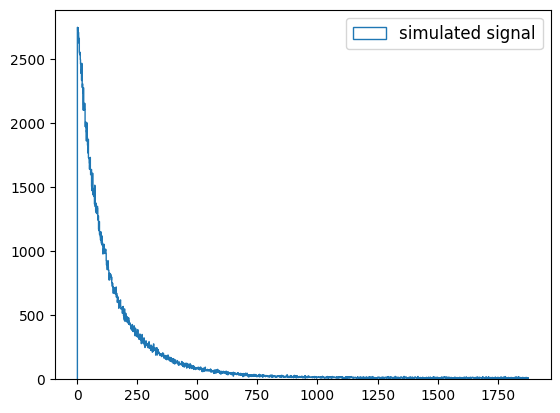

In [ ]:
#Example of simulation of 1 signal based on 3 weeks of data taking
a= simulation(baseline_perday*30.9, int(350022), create_pictures="yes")

In [ ]:
#Values from the signal To compare withe xperimental data and verify the simulation
signal= a[0]
print("After 5 tau_short:")
print('S(450) = ', signal[448:453])
print('S(650) = ', signal[648:653])
print('S(850) = ', signal[848:853])
print("After 5 tau_long:")
print('S(1050) = ', signal[1048:1053])
print('S(1250) = ', signal[1248:1253])
print('S(1450) = ', signal[1448:1453])
print('S(1650) = ', signal[1648:1653])

After 5 tau_short:
S(450) =  [121. 112. 119. 103. 127.]
S(650) =  [39. 24. 55. 41. 39.]
S(850) =  [20. 22. 15. 32. 22.]
After 5 tau_long:
S(1050) =  [14. 20. 19. 12. 14.]
S(1250) =  [ 7. 14. 14. 17. 12.]
S(1450) =  [12. 13.  6.  9. 11.]
S(1650) =  [14. 12. 14. 12.  9.]


# Definition of the fitting functions
### Fit full function fits the data to an exponential + Baseline with no previous estimation

### The other two functions first estimate the baseline by either an arithmetic mean or a pol0 fit and then use the statistics from this estimation as constraints for the full fitting

In [ ]:
def fitting_function(base_input, signal, time_bins, bl_cut=7, estimation = "mean"):
    #first estimate baseline
    if estimation == "mean":
      base_est = np.mean(signal[bl_cut*tau_long:])
      base_std = np.std(signal[bl_cut*tau_long:])/np.sqrt(len(signal))
    elif estimation == "pol0":
      fitted, covd = curve_fit(p0_fit, time_bins[bl_cut*tau_long:], signal[bl_cut*tau_long:], method='trf')
      base_est     = fitted[0]
      base_std     = np.sqrt(covd[0][0])

    #NOw we estimate the tau long part of the curve at diffferent values of tau short

    fit_ashort,fit_tshort,fit_along,fit_tlong,fit_basel=[],[],[],[],[]
    err_ashort,err_tshort,err_along,err_tlong,err_basel=[],[],[],[],[]

    for i in [5,6,7,8]:
      cut = i*tau_short
      x   = time_bins[cut:]
      y   = signal[cut:]

      bound =([-np.inf,-np.inf,base_est-5*base_std], [np.inf,np.inf,base_est + 5*base_std])
      fitting,cov = curve_fit(tau_long_exp, x, y, p0=(signal[0], 100, base_est), bounds=bound)

      amp_long_est = fitting[0]
      amp_long_err = np.sqrt(cov[0][0])
      tau_long_est = fitting[1]
      tau_long_err = np.sqrt(cov[1][1])
      base_prime   = fitting[2]
      base_p_err   = np.sqrt(cov[2][2])

      bounds_low  = [-np.inf,-np.inf,amp_long_est - 5*amp_long_err,
                     tau_long_est - 5*tau_long_err, base_prime - 5*base_p_err]
      bounds_high = [np.inf, np.inf,amp_long_est + 5*amp_long_err,
                     tau_long_est + 5*tau_long_err, base_prime + 5*base_p_err]

      # for each value obtained in these fits, we fit the full function
      full_fit, cove = curve_fit(full_function,signal,time_bins,
                                 p0=(1,1,
                                     amp_long_est,tau_long_est,base_prime),
                                 bounds=(bounds_low,bounds_high))

      fit_ashort.append(full_fit[0])
      fit_tshort.append(full_fit[1])
      fit_along.append(full_fit[2])
      fit_tlong.append(full_fit[3])
      fit_basel.append(full_fit[4])

      err_ashort.append(np.sqrt(cove[0][0]))
      err_tshort.append(np.sqrt(cove[1][1]))
      err_along.append(np.sqrt(cove[2][2]))
      err_tlong.append(np.sqrt(cove[3][3]))
      err_basel.append(np.sqrt(cove[4][4]))

    #get ratios between amplitudes anf the pulls of the physical measurements

    fit_ratio = [fit_ashort[i]/fit_along[i] for i in range(len(fit_ashort))]
    err_ratio = [fit_ratio[i]*np.sqrt((err_ashort[i]/fit_ashort[i])**2+(err_along[i]/fit_along[i])**2) for i in range(len(fit_ratio))]

    pull_tshort = [(fit_tshort[i]-tau_short)/err_tshort[i] for i in range(len(fit_tshort))]
    pull_tlong  = [(fit_tlong[i]-tau_long)/err_tlong[i]  for i in range(len(fit_tlong))]
    pull_ratio  = [(fit_ratio[i]-ratio)/err_ratio[i] for i in range(len(fit_ratio))]
    pull_basel  = [(fit_basel[i]-ratio)/err_basel[i] for i in range(len(fit_basel))]

    print("fit:", fit_tshort[0], fit_tlong[0])
    print("fit:", fit_ashort[0], fit_along[0],fit_ratio[0])

    return (fit_tshort, err_tshort, pull_tshort, fit_tlong, err_tlong, pull_tlong,
            fit_basel, err_basel, pull_basel, fit_ratio, err_ratio, pull_ratio)

# Function that pulls simulation results

### This funcation outputs 9 Dataframes of 35 columns. Every Dataframe corresponds to a different method of estimation of the baseline before fitting the function. The columns instead represent the data obtained for the fitting  parameters, based on different ranges of fitting.

In [ ]:
def pull_sim_statistics(timeframe, n_sims):
    baseline = baseline_perday*timeframe
    numberofentries = int(week*timeframe/7)

    #When we finally decide which multiple of taushort to take, this list will be reduced so beautifully
    col_names  = ["taus_5s", "taus_6s","taus_7s", "taus_8s",
                  "errS_5s","errS_6s","errS_7s","errS_8s",
                  "Tspull_5s","Tspull_6s","Tspull_7s","Tspull_8s",
                  "taul_5s", "taul_6s","taul_7s", "taul_8s",
                  "errL_5s","errL_6s","errL_7s","errL_8s",
                  "Tlpull_5s","Tlpull_6s","Tlpull_7s","Tlpull_8s",
                  "base_5s", "base_6s","base_7s", "base_8s",
                  "errB_5s","errB_6s","errB_7s","errB_8s",
                  "Bpull_5s","Bpull_6s","Bpull_7s","Bpull_8s",
                  "ratio_5s", "ratio_6s","ratio_7s", "ratio_8s",
                  "errR_5s","errR_6s","errR_7s","errR_8s",
                  "Rpull_5s","Rpull_6s","Rpull_7s","Rpull_8s"]

    rows = []
    for i in range(n_sims):
        print("Running sim #", i+1)
        counts_signal, bin_centers = simulation(baseline, numberofentries)
        print('fitting full function:')
        results_tuple = fitting_function(baseline, counts_signal, bin_centers)
        tauS,errorS,pullS,tauL,errorL,pullL,base,errB,pullB,ratio,errR,pullR= results_tuple
        rows.append(tauS+errorS+pullS+tauL+errorL+pullL+base+errB+pullB+ratio+errR+pullR)

        clear_output(wait ="True")

    df_full   = pd.DataFrame(rows, columns=col_names)

    return df_full

## Now running the pull_sim_statistics that run the given number of simulations

In [ ]:
stats  = pull_sim_statistics(7,1000)
stats.to_csv("Week_DoubleExp.csv")

In [ ]:
stats3  = pull_sim_statistics(21,1000)
stats3.to_csv("3Week_DoubleExp.csv"%name)

In [ ]:
stats5  = pull_sim_statistics(35,1000)
stats5.to_csv("5Week_DoubleExp.csv"%name)

## 1000 Simulation Histogram
 Functions that create Plots and final data results for each of the parameters obatined during fitting of 1000 simulated signals

In [ ]:
# Function that creates a single graph with many histograms for different fits of
# one parameter and returns the final results
def single_hist(dataf, array, naming, create_figures ="yes"):
  results = []
  stddev  = []
  for cut in array:
    counts, bines,_ = plt.hist(dataf[cut],bins=50,density ="True",
                            histtype="step")
    bin_mids = (bines[:-1] + bines[1:])/2.
    parameters, _ = curve_fit(pana_gauss, bin_mids, counts, p0=(bines[25], bines[25]**0.5))
    results.append(parameters[0])
    stddev.append(parameters[1])

  plt.title("Simulated %s for a %s period" %naming)
  plt.legend(["%s : %.3f +- %.2f" %(i,j,k) for i,j,k in zip(array, results,stddev)])

  fig = plt.gcf()
  if create_figures=="yes":
    plt.show()
  fig.savefig("%s_%s.png" %naming)
  plt.close()

  return results


#this function runs single)hist for all of the parameters in a results dataframe
def plotter(dataf, naming="gen", create_figures="yes"):
  tau_columnns = dataf.columns.values.tolist()

  tauS_vals   = single_hist(dataf, tau_columnns[0:5]  , ("TauShort", naming), create_figures)
  errS_vals   = single_hist(dataf, tau_columnns[5:10] , ("TauShort_Errors", naming), create_figures)
  pullS_vals  = single_hist(dataf, tau_columnns[10:15], ("TauShort_Pulls", naming), create_figures)
  tauL_vals   = single_hist(dataf, tau_columnns[15:20], ("TauLong", naming), create_figures)
  errL_vals   = single_hist(dataf, tau_columnns[20:25], ("TauLong_Errors", naming), create_figures)
  pullL_vals  = single_hist(dataf, tau_columnns[25:30], ("TauLong_Pulls", naming), create_figures)
  base_vals   = single_hist(dataf, tau_columnns[30:35], ("Baseline", naming), create_figures)
  errB_vals   = single_hist(dataf, tau_columnns[35:40], ("Baseline_errors", naming), create_figures)
  pullB_vals  = single_hist(dataf, tau_columnns[40:45], ("Baseline_Pulls", naming), create_figures)
  ratio_vals  = single_hist(dataf, tau_columnns[45:50], ("Ratio", naming), create_figures)
  errR_vals   = single_hist(dataf, tau_columnns[50:55], ("Ratio_Errors", naming), create_figures)
  pullR_vals  = single_hist(dataf, tau_columnns[55:60], ("Ratio_Pulls", naming), create_figures)

  return (tauS_vals, errS_vals, pullS_vals, tauL_vals, errL_vals, pullL_vals,
          base_vals, errB_vals, pullB_vals, ratio_vals, errR_vals, pullR_vals)

In [ ]:
#run for one dataframe
dataframetoplot=stats
info= plotter(dataframetoplot, "1Week","yes")

printer =["Tau Short estimation: %.5f +/- %.5f" %(i,j) for i,j in zip(info[0], info[1]) ]
print("Values for simulated week of data taking at different cuts")
for i in printer:
  print(i)

printer =["Tau long estimation: %.5f +/- %.5f" %(i,j) for i,j in zip(info[3], info[4]) ]
print("Values for simulated week of data taking at different cuts")
for i in printer:
  print(i)

print("Baseline for simulated week of data taking at different cuts")
printer =["Baseline estimation: %.5f +/- %.5f" %(i,j) for i,j in zip(info[6], info[7]) ]
for i in printer:
  print(i)

printer =["Tau long estimation: %.5f +/- %.5f" %(i,j) for i,j in zip(info[9], info[10]) ]
print("Values for simulated week of data taking at different cuts")
for i in printer:
  print(i)

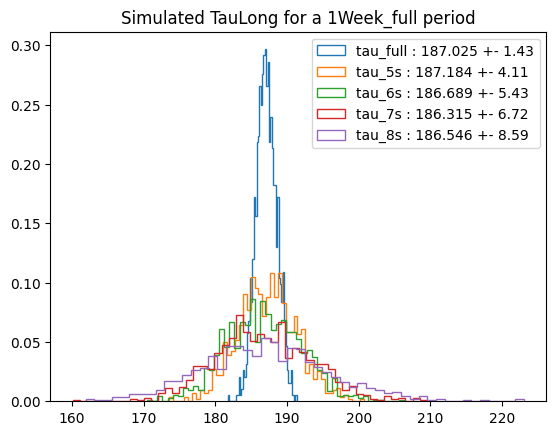

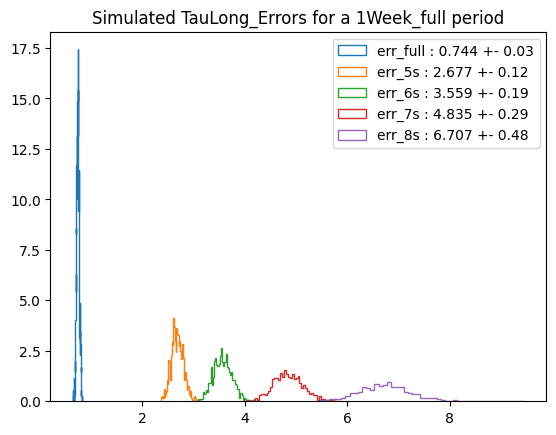

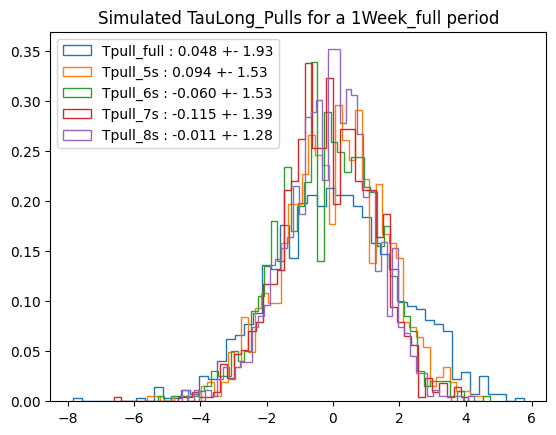

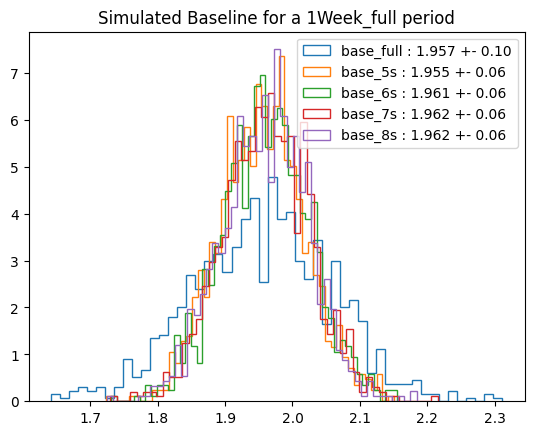

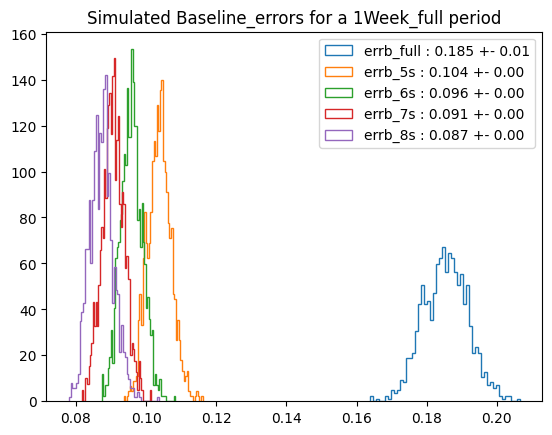

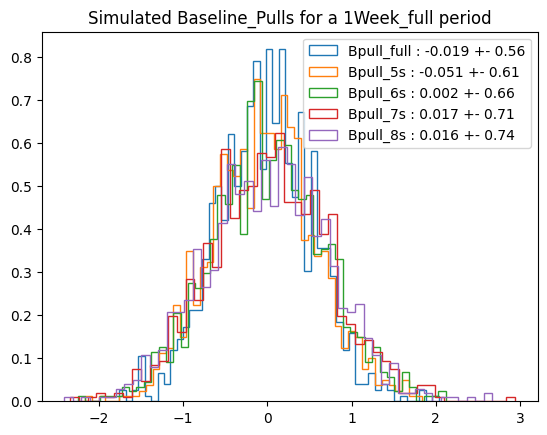

Values for simulated week of data taking at different cuts
Tau long estimation: 187.02471 +/- 0.74401
Tau long estimation: 187.18403 +/- 2.67674
Tau long estimation: 186.68867 +/- 3.55883
Tau long estimation: 186.31462 +/- 4.83469
Tau long estimation: 186.54599 +/- 6.70717
Baseline for simulated week of data taking at different cuts
Baseline estimation: 1.95698 +/- 0.18536
Baseline estimation: 1.95464 +/- 0.10365
Baseline estimation: 1.96077 +/- 0.09568
Baseline estimation: 1.96171 +/- 0.09054
Baseline estimation: 1.96226 +/- 0.08711


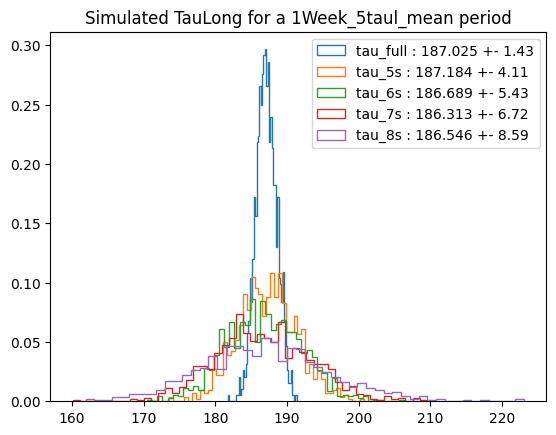

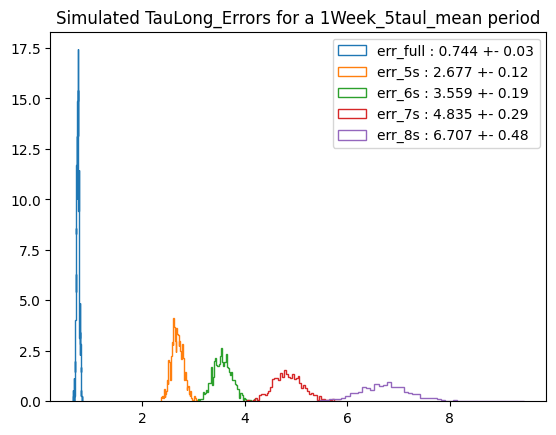

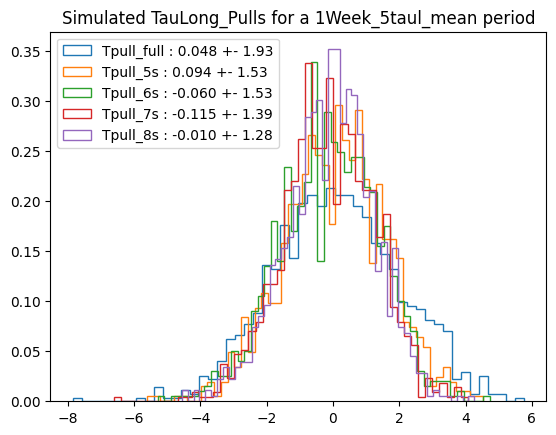

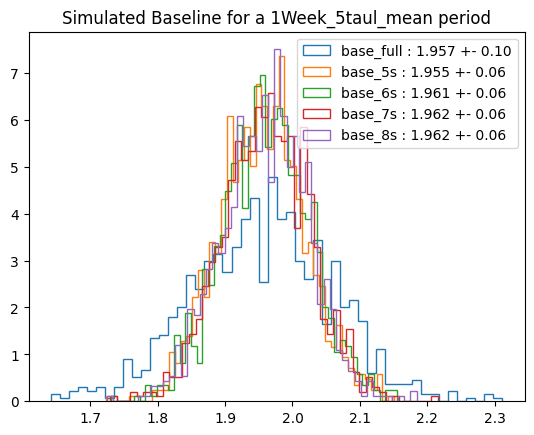

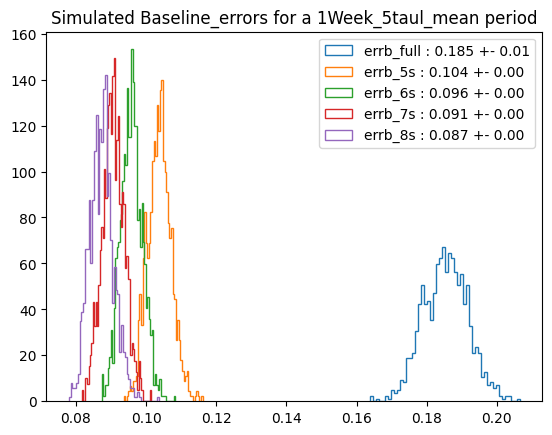

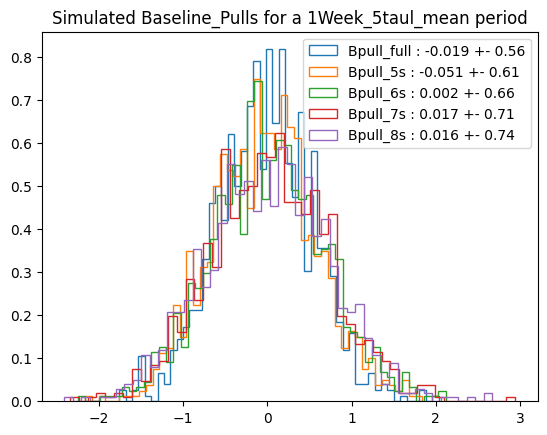

Values for simulated week of data taking at different cuts
Tau long estimation: 187.02470 +/- 0.74401
Tau long estimation: 187.18394 +/- 2.67674
Tau long estimation: 186.68862 +/- 3.55883
Tau long estimation: 186.31307 +/- 4.83469
Tau long estimation: 186.54641 +/- 6.70735
Baseline for simulated week of data taking at different cuts
Baseline estimation: 1.95698 +/- 0.18536
Baseline estimation: 1.95464 +/- 0.10365
Baseline estimation: 1.96077 +/- 0.09568
Baseline estimation: 1.96170 +/- 0.09054
Baseline estimation: 1.96226 +/- 0.08711


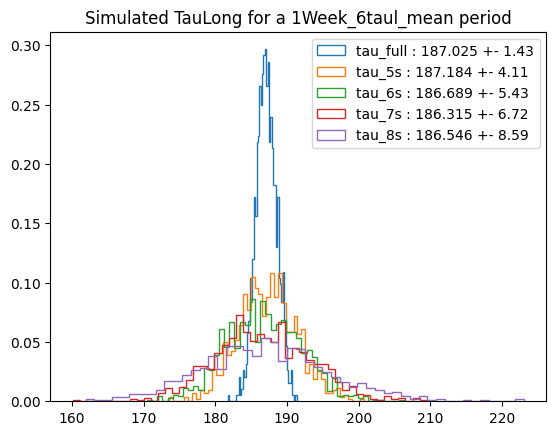

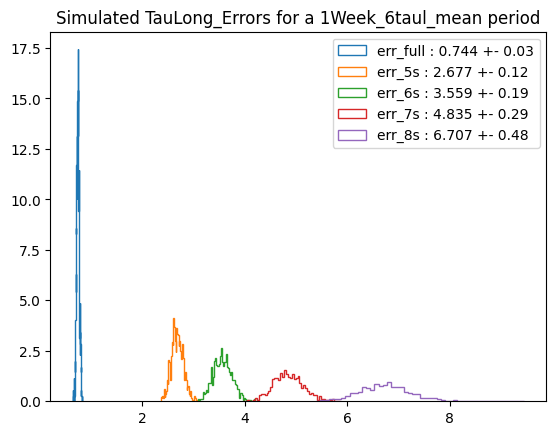

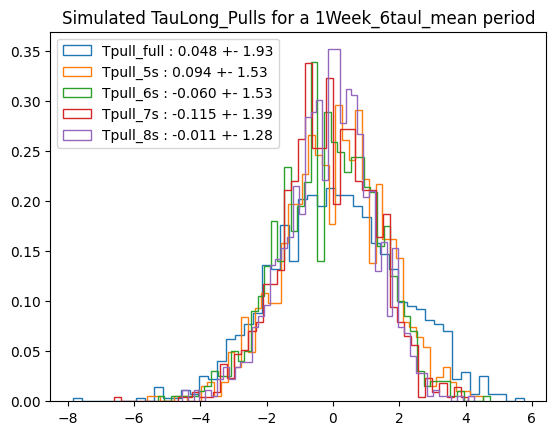

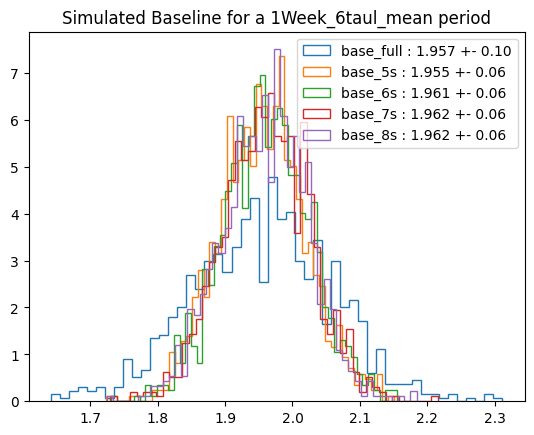

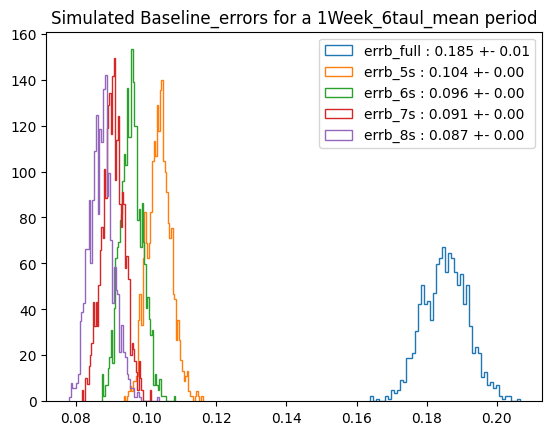

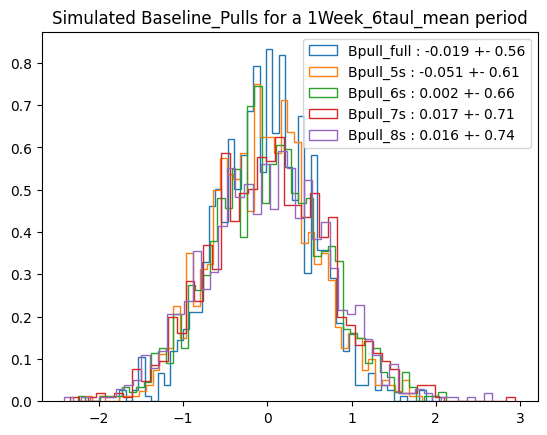

Values for simulated week of data taking at different cuts
Tau long estimation: 187.02469 +/- 0.74401
Tau long estimation: 187.18394 +/- 2.67674
Tau long estimation: 186.68866 +/- 3.55883
Tau long estimation: 186.31466 +/- 4.83469
Tau long estimation: 186.54619 +/- 6.70734
Baseline for simulated week of data taking at different cuts
Baseline estimation: 1.95699 +/- 0.18536
Baseline estimation: 1.95465 +/- 0.10365
Baseline estimation: 1.96077 +/- 0.09568
Baseline estimation: 1.96171 +/- 0.09054
Baseline estimation: 1.96225 +/- 0.08711


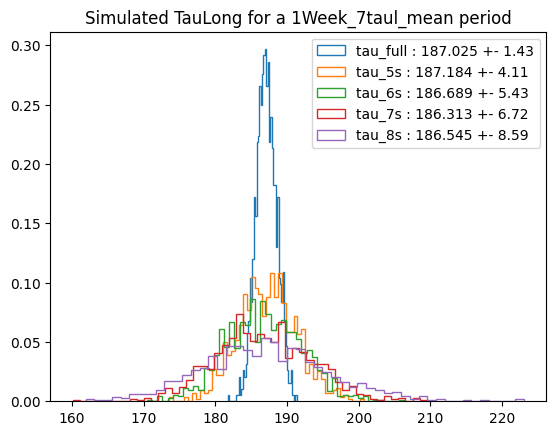

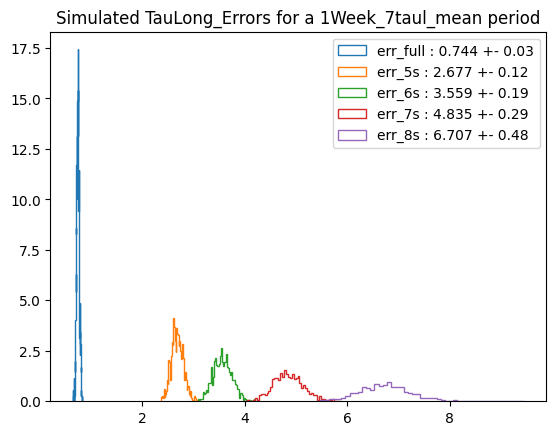

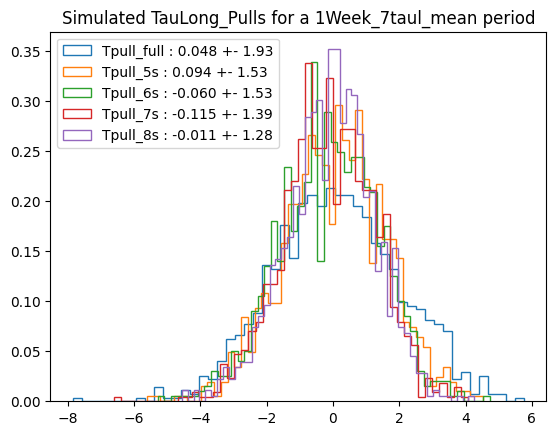

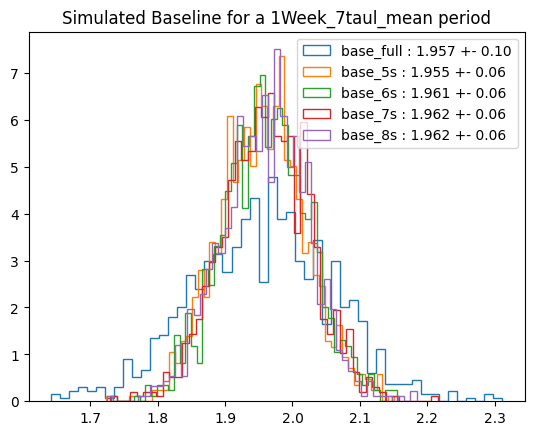

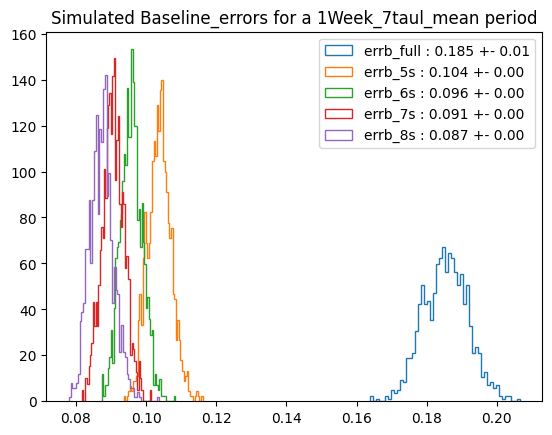

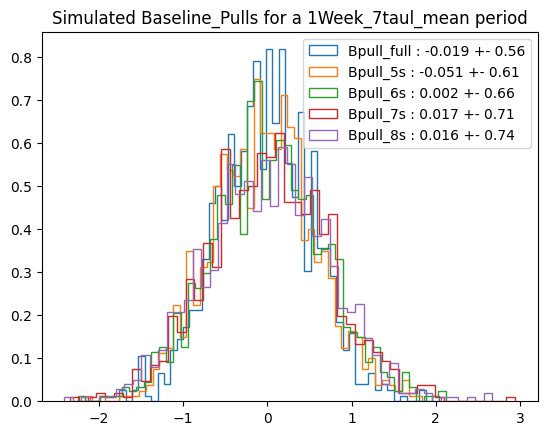

Values for simulated week of data taking at different cuts
Tau long estimation: 187.02470 +/- 0.74401
Tau long estimation: 187.18394 +/- 2.67674
Tau long estimation: 186.68854 +/- 3.55883
Tau long estimation: 186.31307 +/- 4.83471
Tau long estimation: 186.54479 +/- 6.70734
Baseline for simulated week of data taking at different cuts
Baseline estimation: 1.95698 +/- 0.18536
Baseline estimation: 1.95464 +/- 0.10365
Baseline estimation: 1.96077 +/- 0.09568
Baseline estimation: 1.96171 +/- 0.09054
Baseline estimation: 1.96225 +/- 0.08711


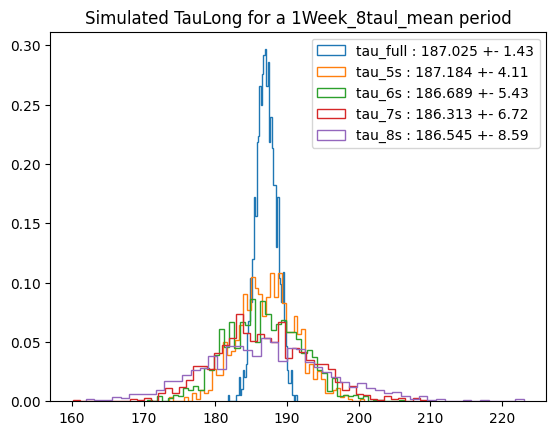

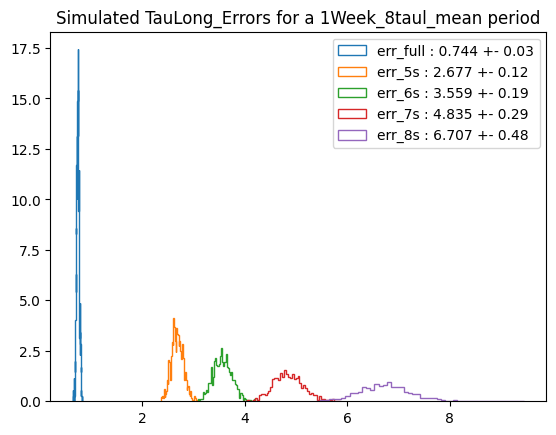

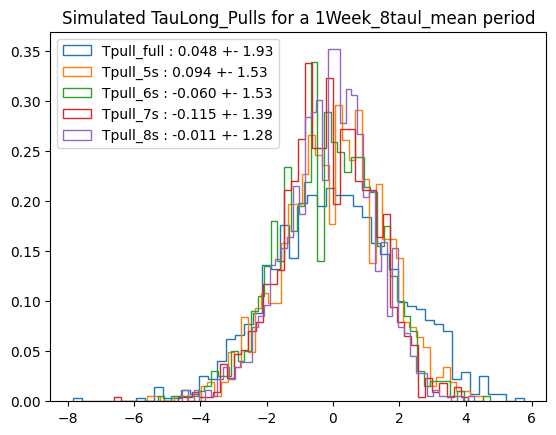

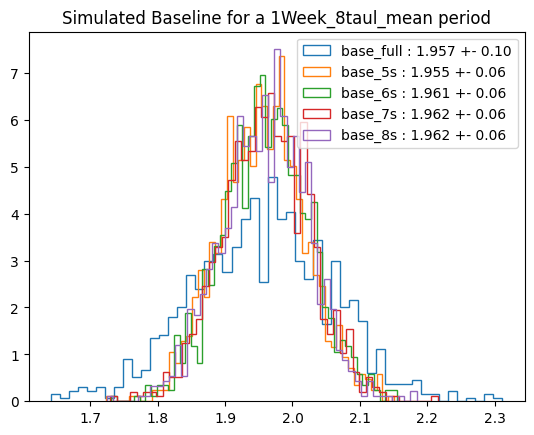

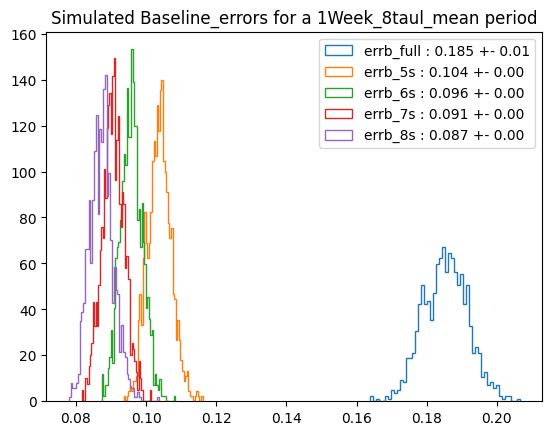

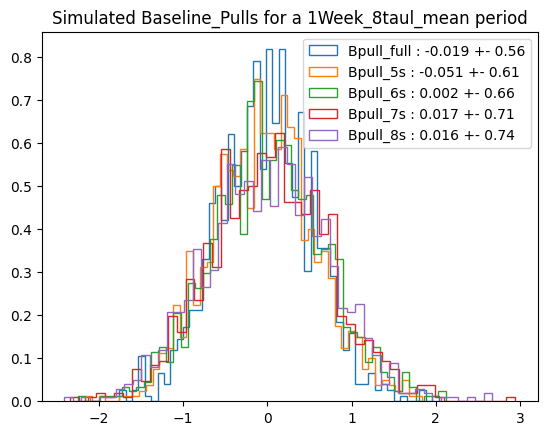

Values for simulated week of data taking at different cuts
Tau long estimation: 187.02470 +/- 0.74401
Tau long estimation: 187.18394 +/- 2.67674
Tau long estimation: 186.68855 +/- 3.55883
Tau long estimation: 186.31314 +/- 4.83470
Tau long estimation: 186.54473 +/- 6.70734
Baseline for simulated week of data taking at different cuts
Baseline estimation: 1.95698 +/- 0.18536
Baseline estimation: 1.95464 +/- 0.10365
Baseline estimation: 1.96077 +/- 0.09568
Baseline estimation: 1.96171 +/- 0.09054
Baseline estimation: 1.96225 +/- 0.08711


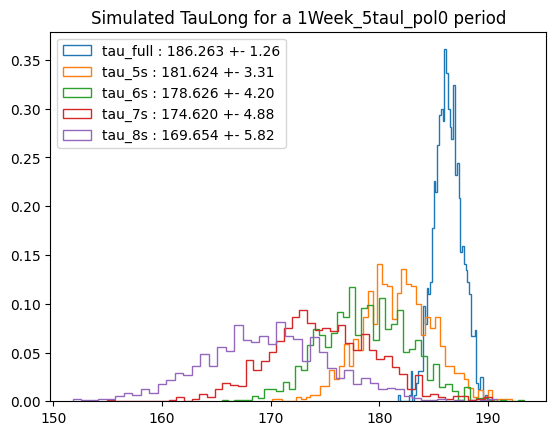

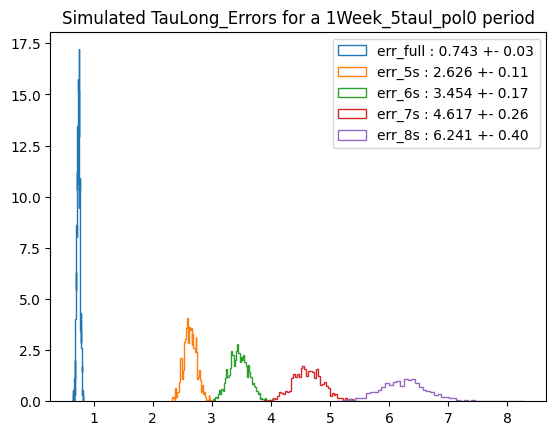

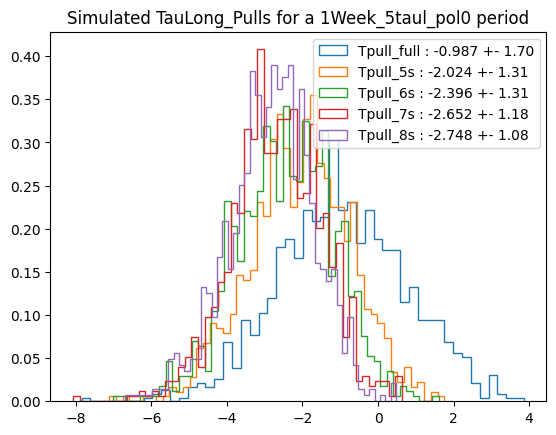

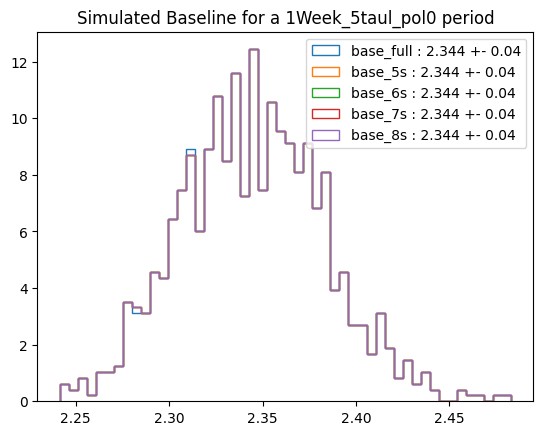

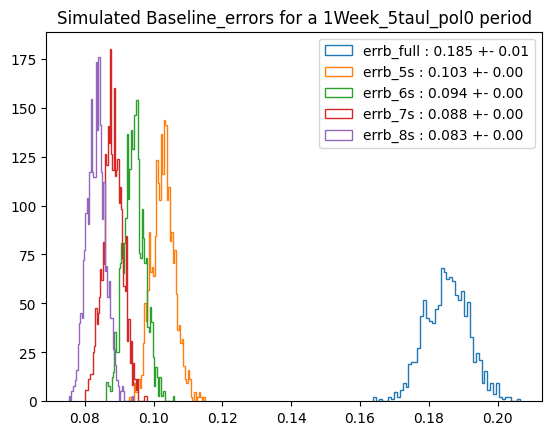

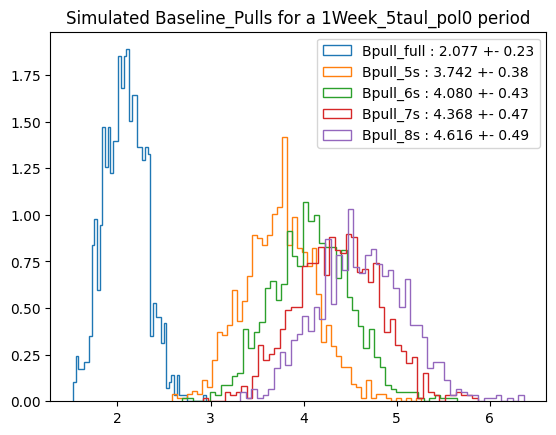

Values for simulated week of data taking at different cuts
Tau long estimation: 186.26260 +/- 0.74282
Tau long estimation: 181.62437 +/- 2.62639
Tau long estimation: 178.62632 +/- 3.45416
Tau long estimation: 174.62026 +/- 4.61725
Tau long estimation: 169.65390 +/- 6.24092
Baseline for simulated week of data taking at different cuts
Baseline estimation: 2.34362 +/- 0.18535
Baseline estimation: 2.34363 +/- 0.10271
Baseline estimation: 2.34363 +/- 0.09417
Baseline estimation: 2.34363 +/- 0.08809
Baseline estimation: 2.34363 +/- 0.08322


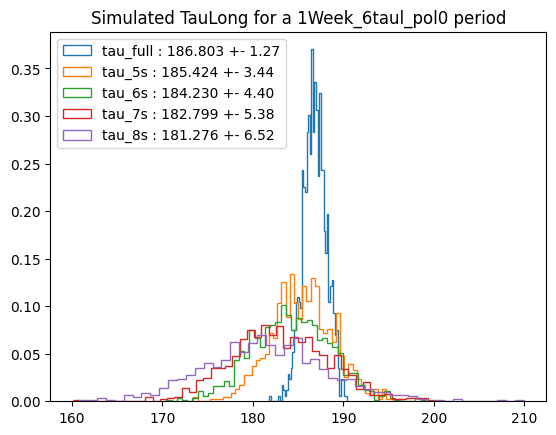

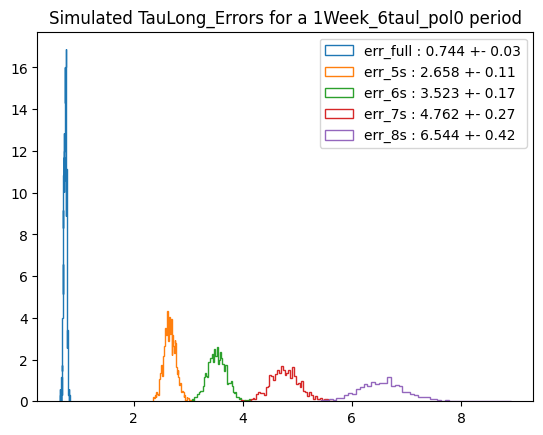

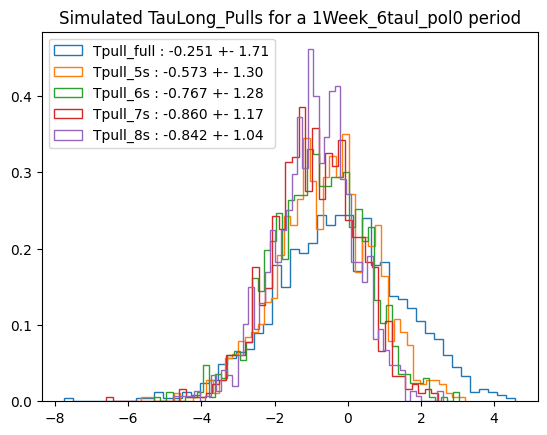

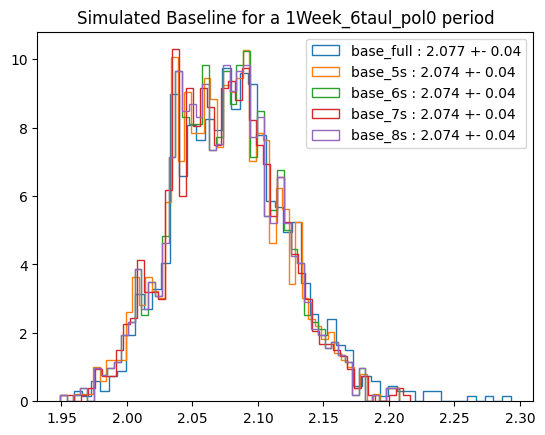

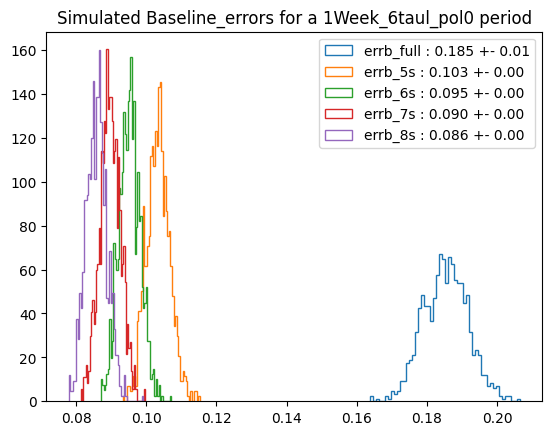

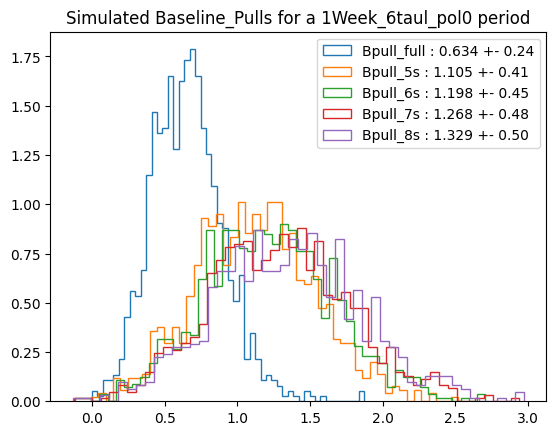

Values for simulated week of data taking at different cuts
Tau long estimation: 186.80346 +/- 0.74353
Tau long estimation: 185.42351 +/- 2.65812
Tau long estimation: 184.22997 +/- 3.52270
Tau long estimation: 182.79934 +/- 4.76205
Tau long estimation: 181.27618 +/- 6.54398
Baseline for simulated week of data taking at different cuts
Baseline estimation: 2.07729 +/- 0.18532
Baseline estimation: 2.07370 +/- 0.10326
Baseline estimation: 2.07389 +/- 0.09511
Baseline estimation: 2.07401 +/- 0.08962
Baseline estimation: 2.07356 +/- 0.08567


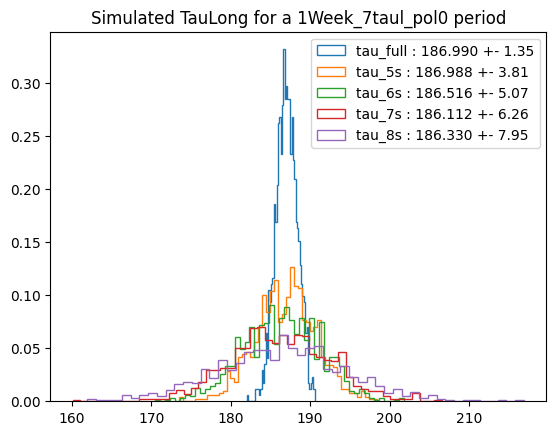

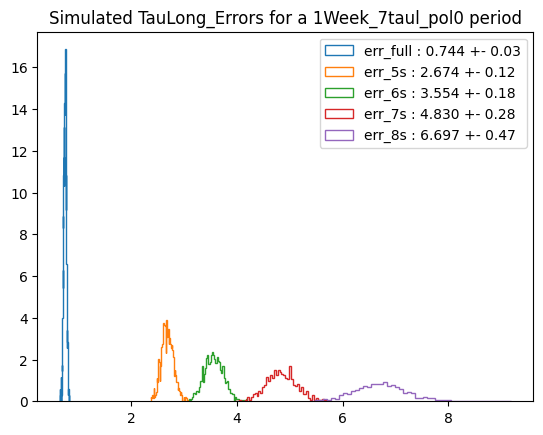

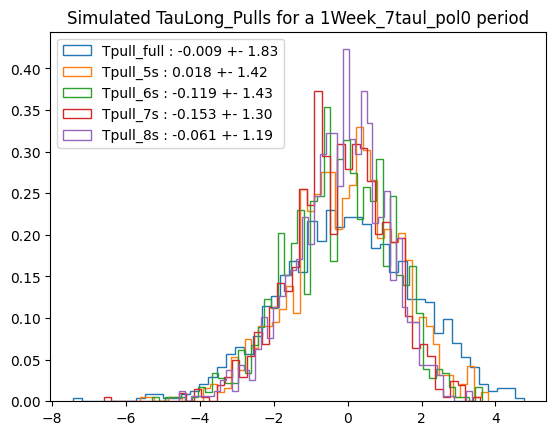

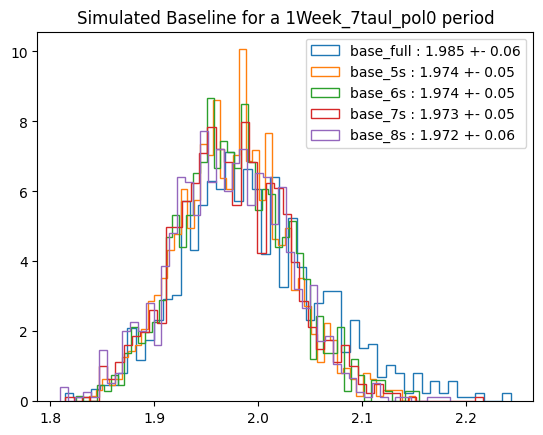

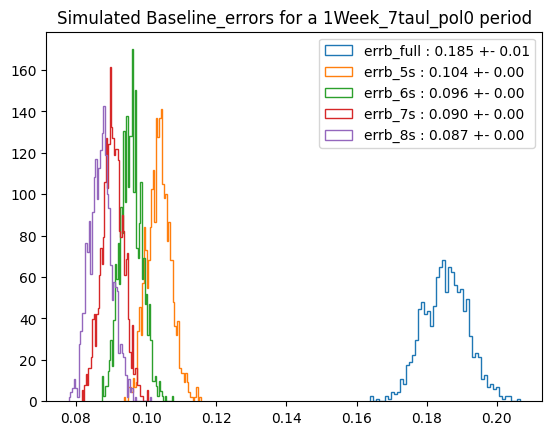

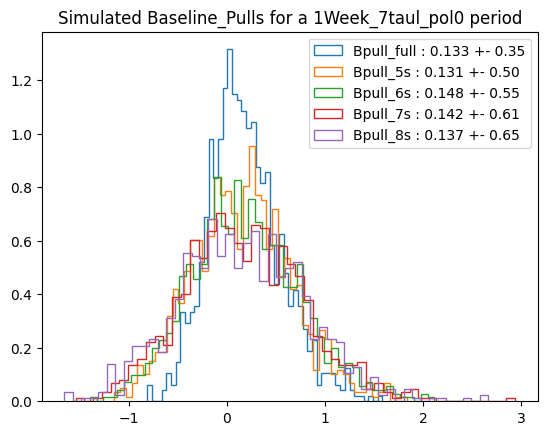

Values for simulated week of data taking at different cuts
Tau long estimation: 186.99043 +/- 0.74391
Tau long estimation: 186.98819 +/- 2.67361
Tau long estimation: 186.51626 +/- 3.55421
Tau long estimation: 186.11186 +/- 4.82994
Tau long estimation: 186.33032 +/- 6.69668
Baseline for simulated week of data taking at different cuts
Baseline estimation: 1.98463 +/- 0.18535
Baseline estimation: 1.97373 +/- 0.10358
Baseline estimation: 1.97444 +/- 0.09560
Baseline estimation: 1.97288 +/- 0.09042
Baseline estimation: 1.97247 +/- 0.08699


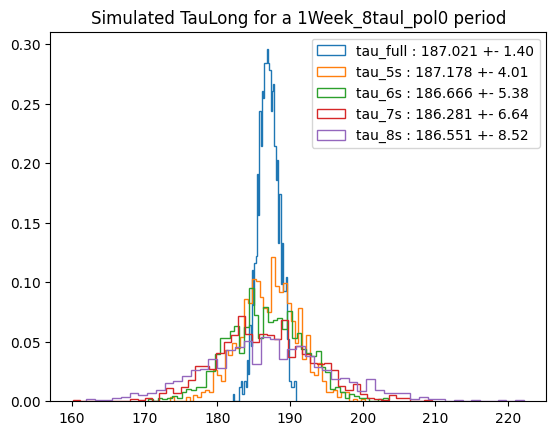

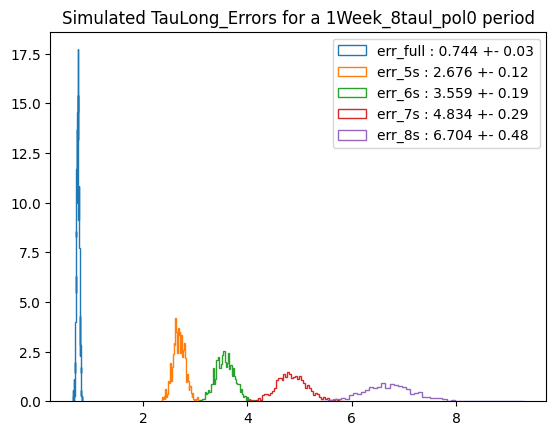

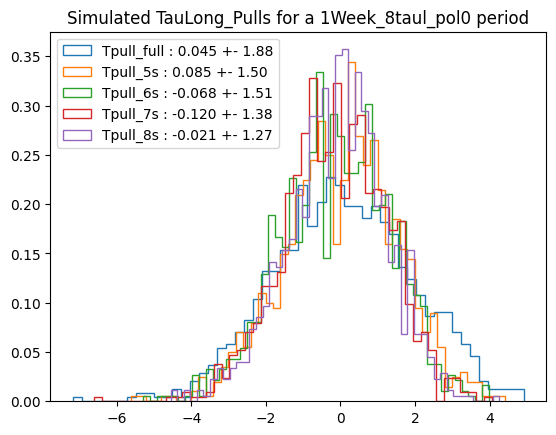

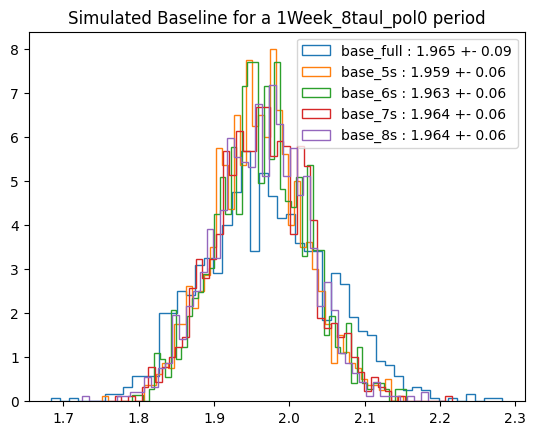

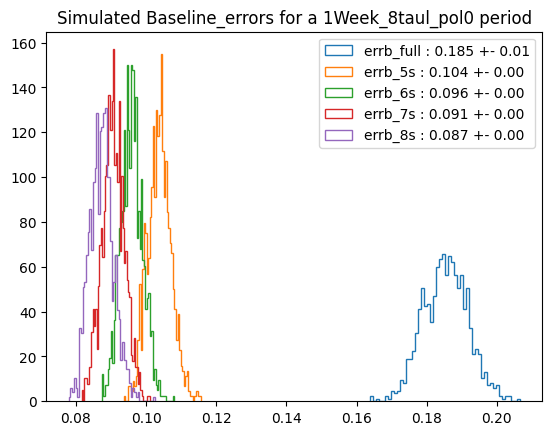

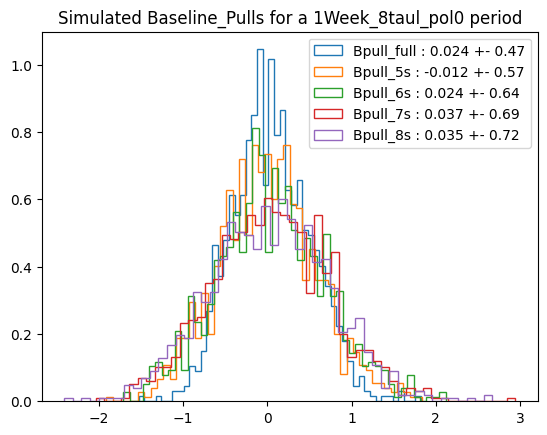

Values for simulated week of data taking at different cuts
Tau long estimation: 187.02076 +/- 0.74394
Tau long estimation: 187.17751 +/- 2.67601
Tau long estimation: 186.66555 +/- 3.55857
Tau long estimation: 186.28130 +/- 4.83392
Tau long estimation: 186.55116 +/- 6.70353
Baseline for simulated week of data taking at different cuts
Baseline estimation: 1.96470 +/- 0.18536
Baseline estimation: 1.95907 +/- 0.10364
Baseline estimation: 1.96273 +/- 0.09567
Baseline estimation: 1.96369 +/- 0.09052
Baseline estimation: 1.96394 +/- 0.08708


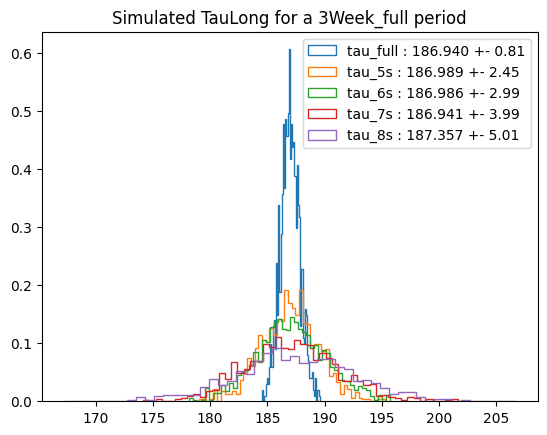

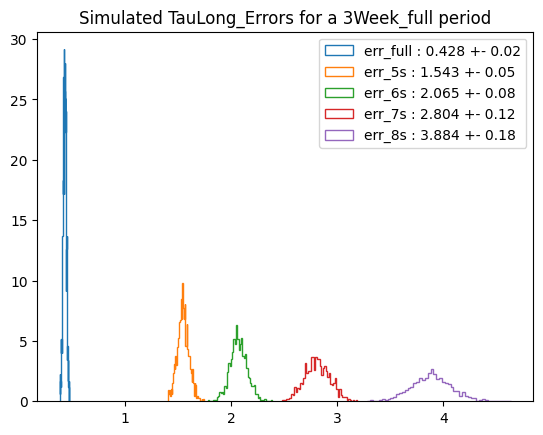

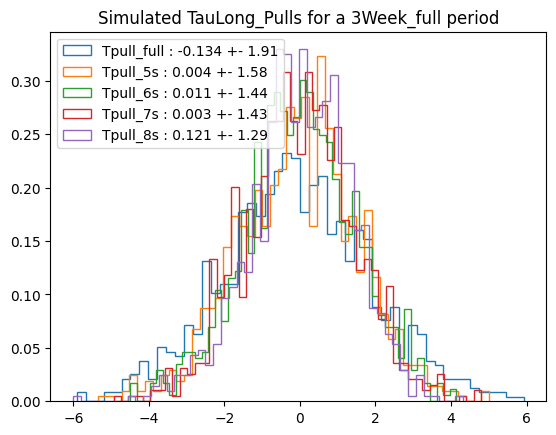

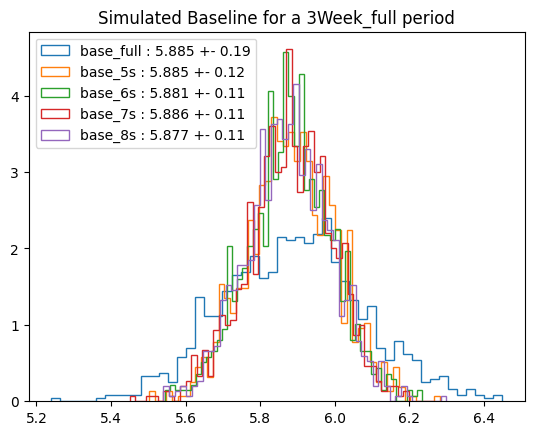

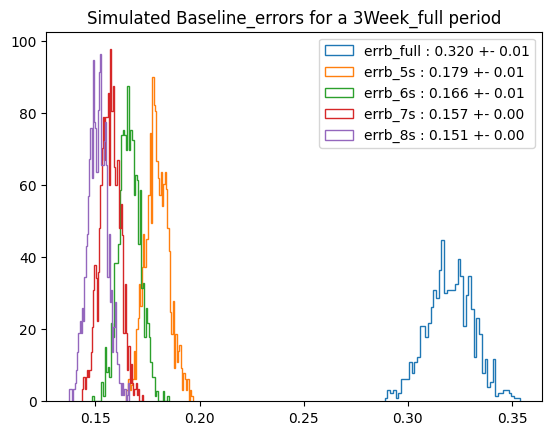

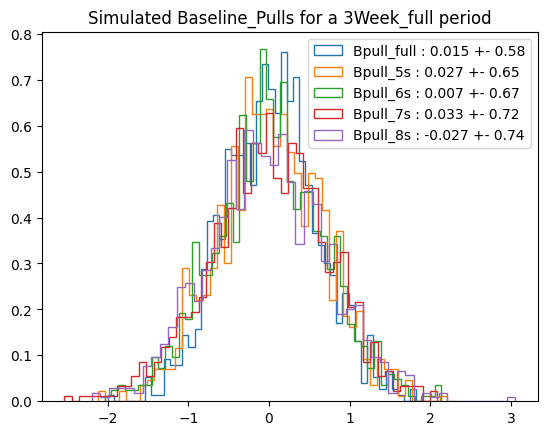

Values for simulated week of data taking at different cuts
Tau long estimation: 186.94024 +/- 0.42831
Tau long estimation: 186.98876 +/- 1.54259
Tau long estimation: 186.98581 +/- 2.06550
Tau long estimation: 186.94061 +/- 2.80447
Tau long estimation: 187.35655 +/- 3.88430
Baseline for simulated week of data taking at different cuts
Baseline estimation: 5.88538 +/- 0.32029
Baseline estimation: 5.88508 +/- 0.17926
Baseline estimation: 5.88140 +/- 0.16615
Baseline estimation: 5.88631 +/- 0.15691
Baseline estimation: 5.87654 +/- 0.15111


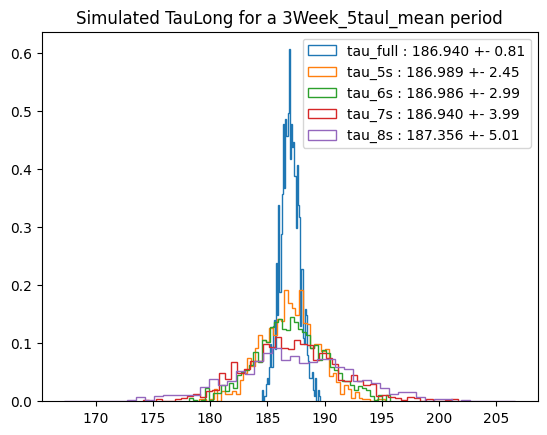

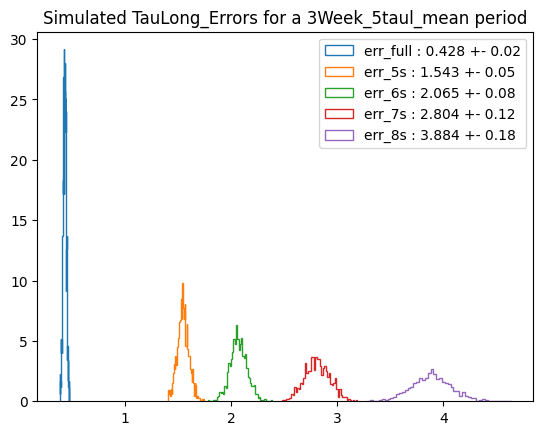

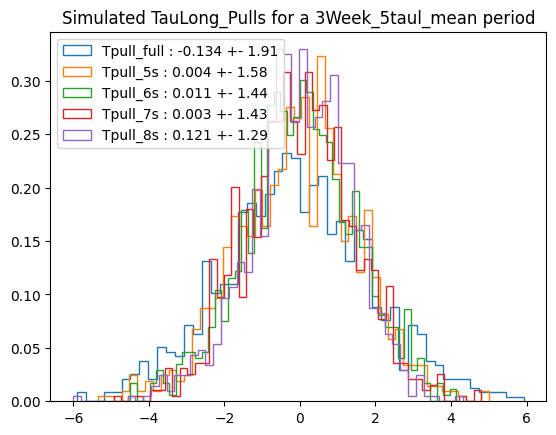

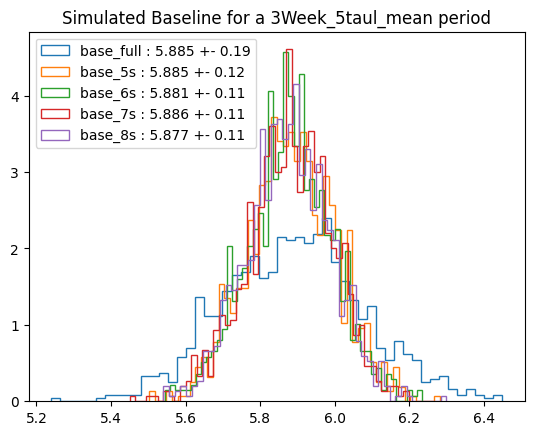

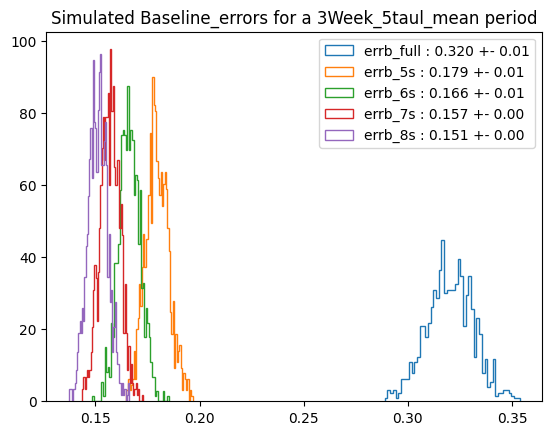

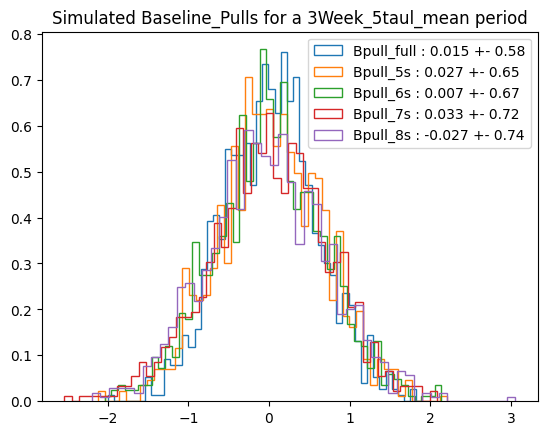

Values for simulated week of data taking at different cuts
Tau long estimation: 186.94024 +/- 0.42831
Tau long estimation: 186.98875 +/- 1.54259
Tau long estimation: 186.98579 +/- 2.06550
Tau long estimation: 186.94045 +/- 2.80447
Tau long estimation: 187.35622 +/- 3.88430
Baseline for simulated week of data taking at different cuts
Baseline estimation: 5.88538 +/- 0.32029
Baseline estimation: 5.88508 +/- 0.17926
Baseline estimation: 5.88140 +/- 0.16615
Baseline estimation: 5.88631 +/- 0.15691
Baseline estimation: 5.87654 +/- 0.15111


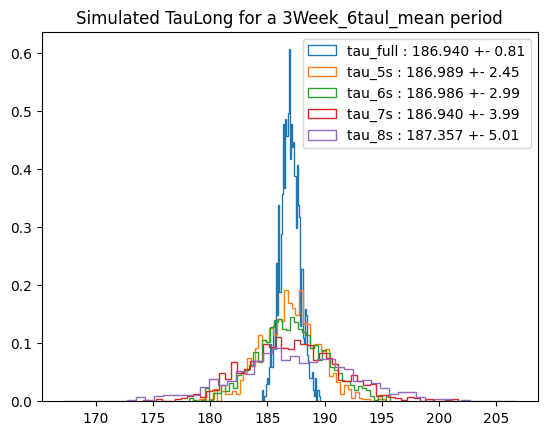

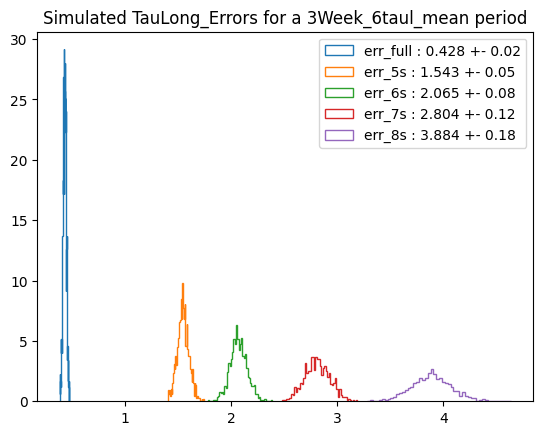

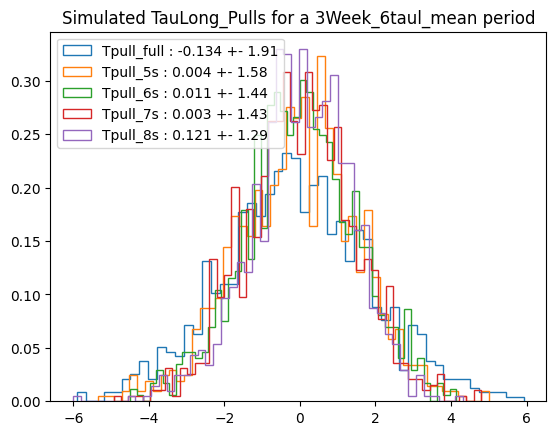

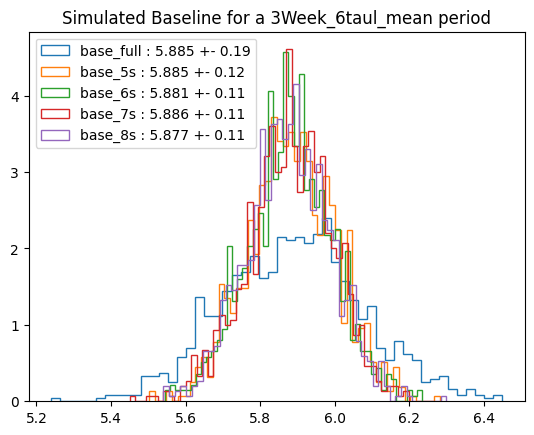

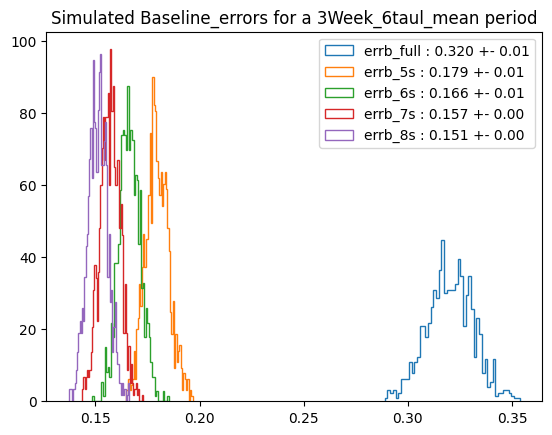

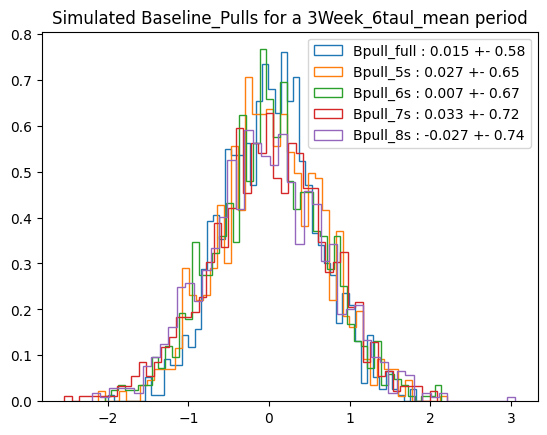

Values for simulated week of data taking at different cuts
Tau long estimation: 186.94024 +/- 0.42831
Tau long estimation: 186.98877 +/- 1.54259
Tau long estimation: 186.98570 +/- 2.06550
Tau long estimation: 186.94039 +/- 2.80447
Tau long estimation: 187.35654 +/- 3.88430
Baseline for simulated week of data taking at different cuts
Baseline estimation: 5.88538 +/- 0.32029
Baseline estimation: 5.88508 +/- 0.17926
Baseline estimation: 5.88140 +/- 0.16615
Baseline estimation: 5.88631 +/- 0.15691
Baseline estimation: 5.87654 +/- 0.15111


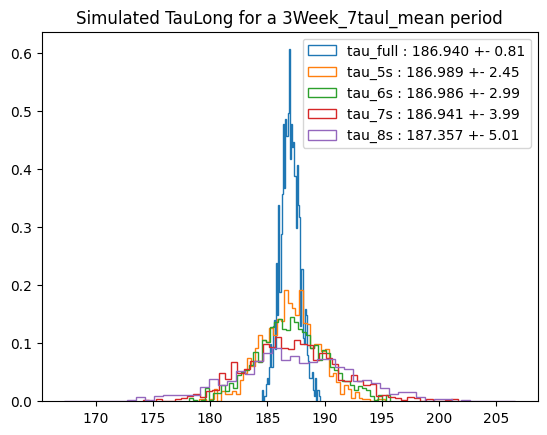

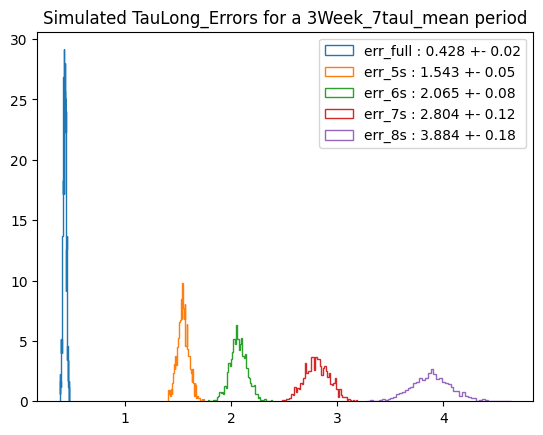

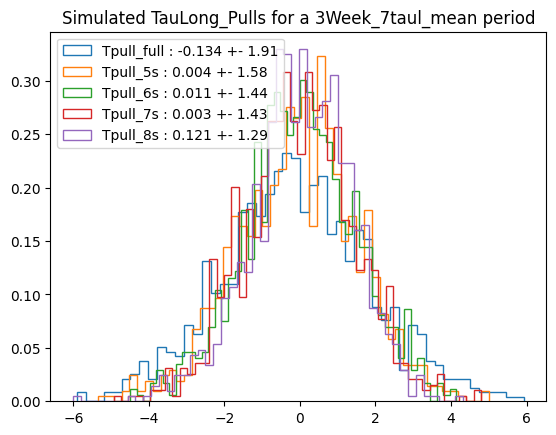

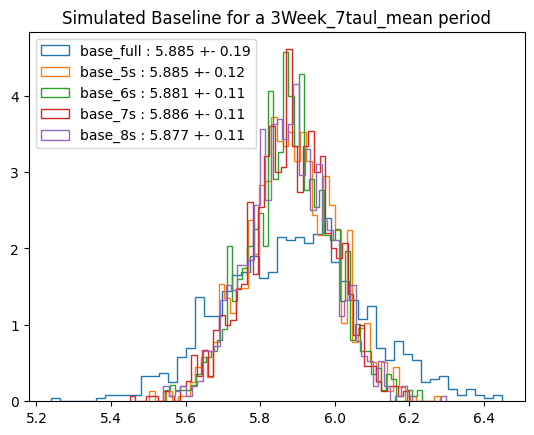

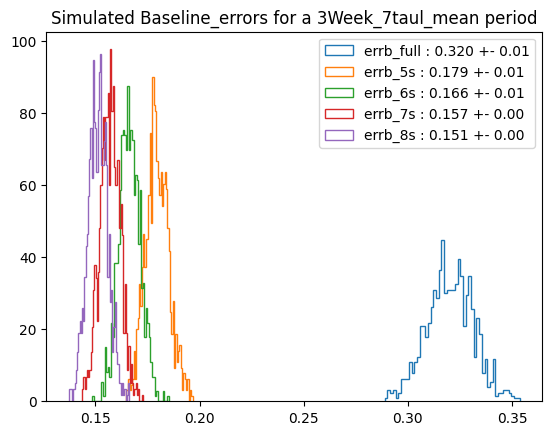

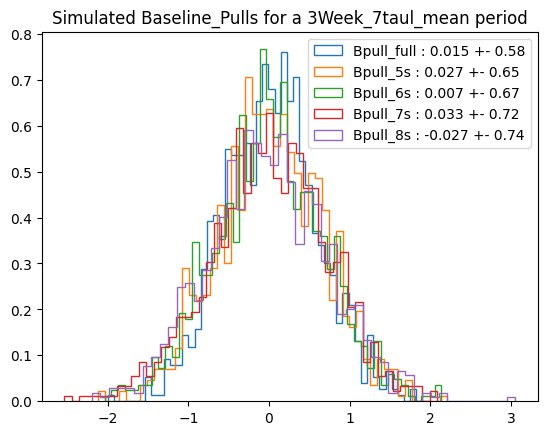

Values for simulated week of data taking at different cuts
Tau long estimation: 186.94024 +/- 0.42831
Tau long estimation: 186.98879 +/- 1.54259
Tau long estimation: 186.98565 +/- 2.06550
Tau long estimation: 186.94051 +/- 2.80447
Tau long estimation: 187.35654 +/- 3.88430
Baseline for simulated week of data taking at different cuts
Baseline estimation: 5.88538 +/- 0.32029
Baseline estimation: 5.88507 +/- 0.17926
Baseline estimation: 5.88140 +/- 0.16615
Baseline estimation: 5.88631 +/- 0.15691
Baseline estimation: 5.87654 +/- 0.15111


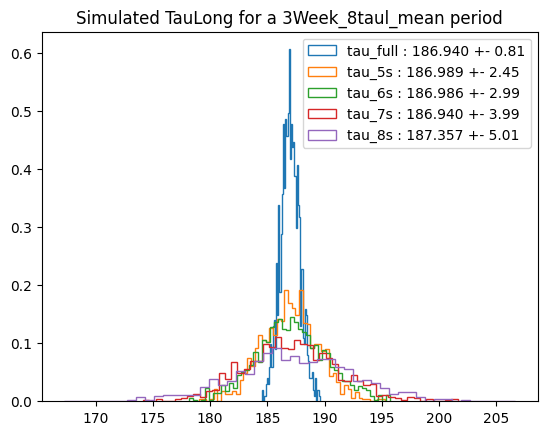

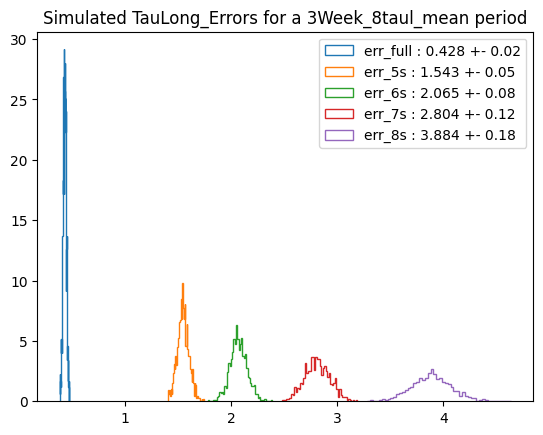

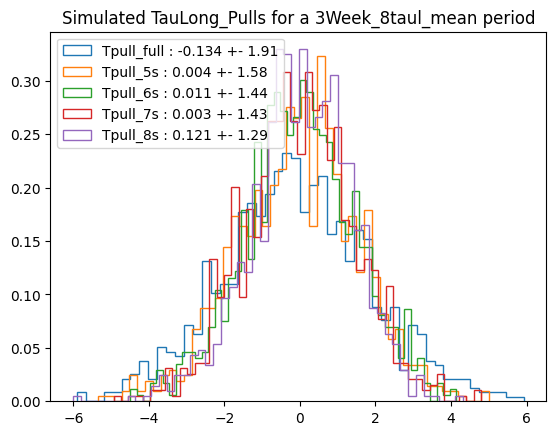

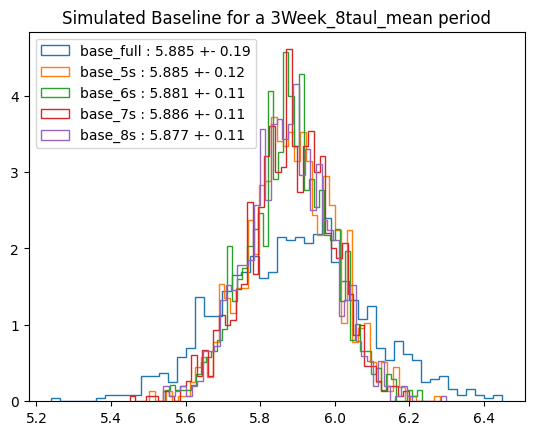

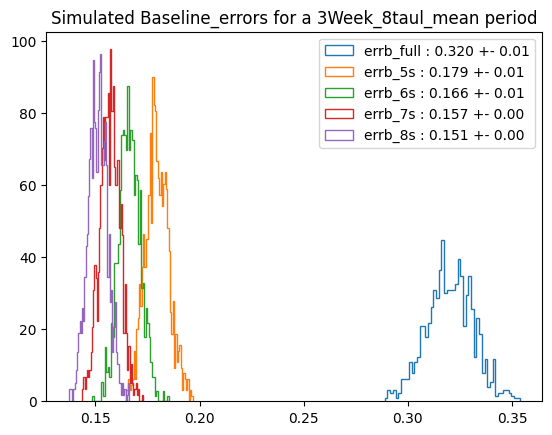

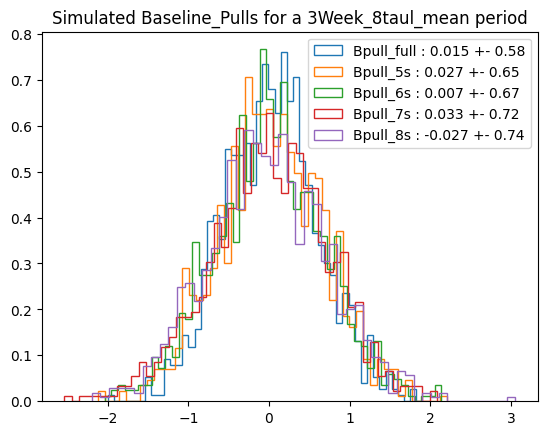

Values for simulated week of data taking at different cuts
Tau long estimation: 186.94024 +/- 0.42831
Tau long estimation: 186.98879 +/- 1.54259
Tau long estimation: 186.98566 +/- 2.06550
Tau long estimation: 186.94049 +/- 2.80447
Tau long estimation: 187.35653 +/- 3.88430
Baseline for simulated week of data taking at different cuts
Baseline estimation: 5.88538 +/- 0.32029
Baseline estimation: 5.88508 +/- 0.17926
Baseline estimation: 5.88140 +/- 0.16615
Baseline estimation: 5.88630 +/- 0.15691
Baseline estimation: 5.87654 +/- 0.15111


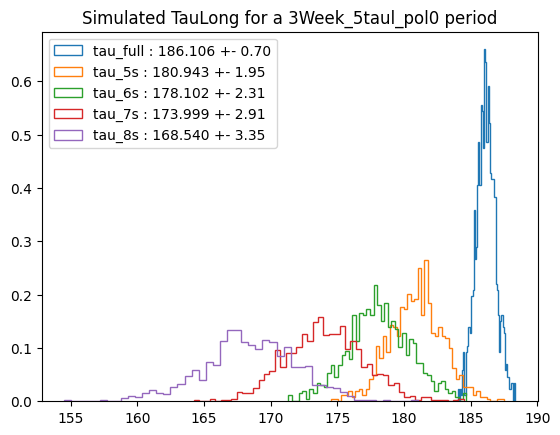

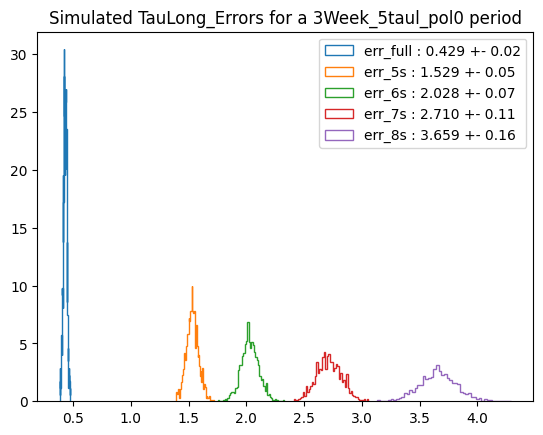

<ipython-input-11-ac9582f801a5>:24: RuntimeWarning: invalid value encountered in double_scalars
  gauss,std = gauss_fitti(bines,counts, (max(bines), max(bines)**0.5))
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


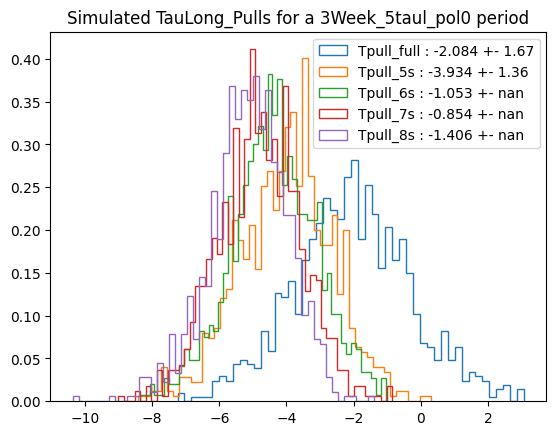

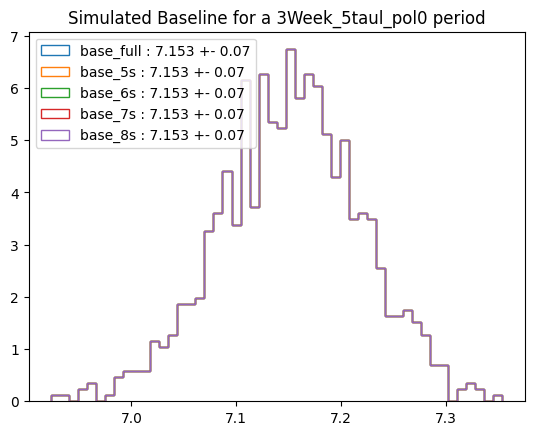

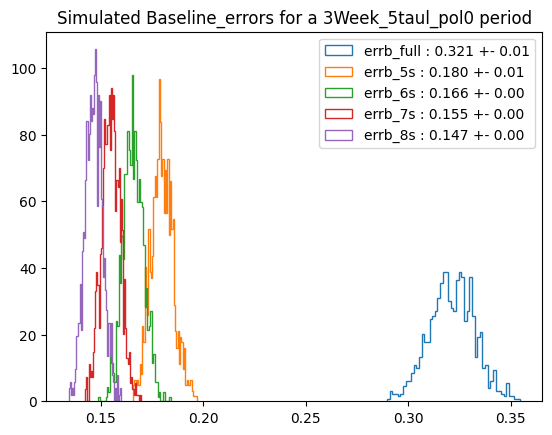

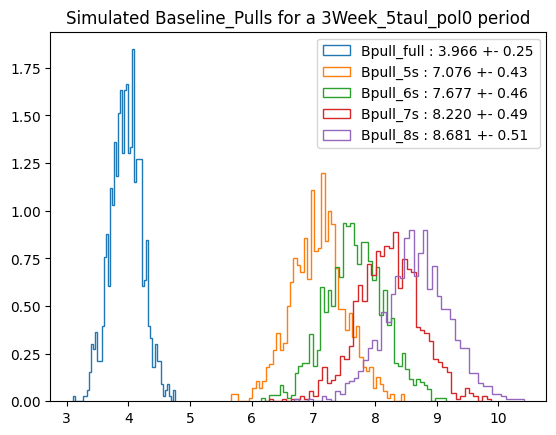

Values for simulated week of data taking at different cuts
Tau long estimation: 186.10568 +/- 0.42878
Tau long estimation: 180.94316 +/- 1.52883
Tau long estimation: 178.10192 +/- 2.02756
Tau long estimation: 173.99863 +/- 2.70999
Tau long estimation: 168.54047 +/- 3.65878
Baseline for simulated week of data taking at different cuts
Baseline estimation: 7.15275 +/- 0.32119
Baseline estimation: 7.15275 +/- 0.17959
Baseline estimation: 7.15275 +/- 0.16563
Baseline estimation: 7.15275 +/- 0.15489
Baseline estimation: 7.15275 +/- 0.14658


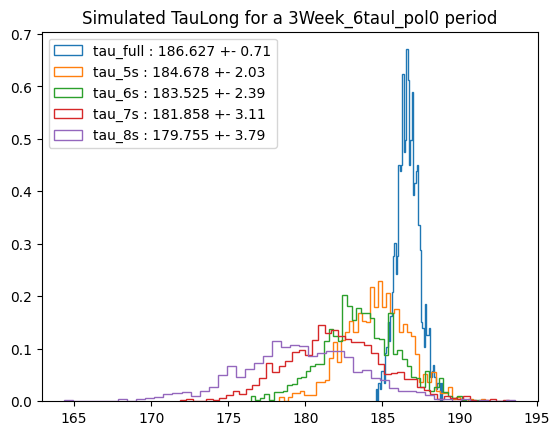

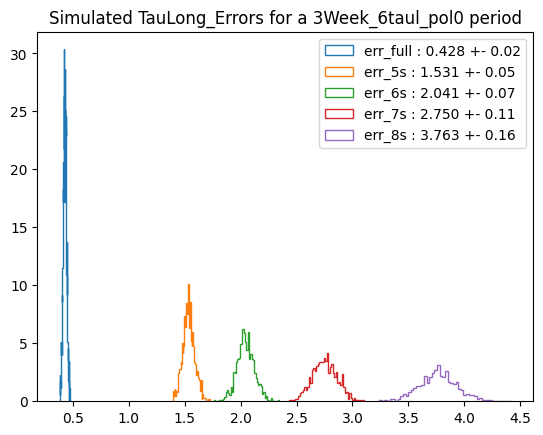

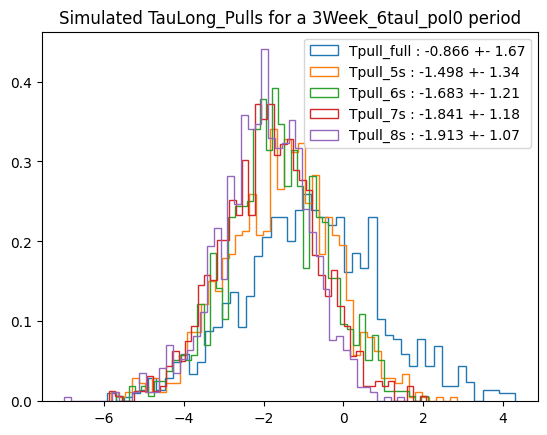

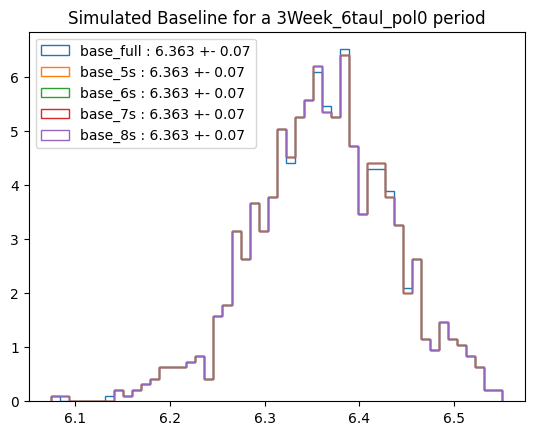

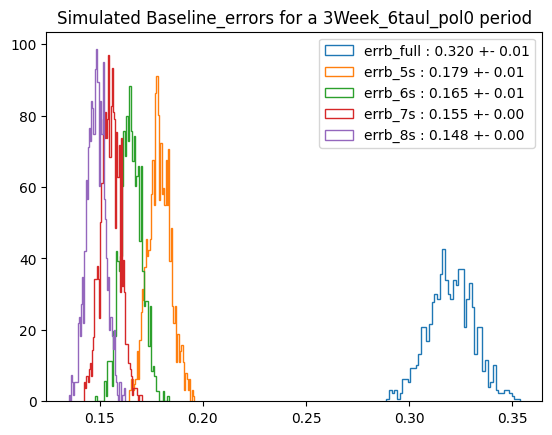

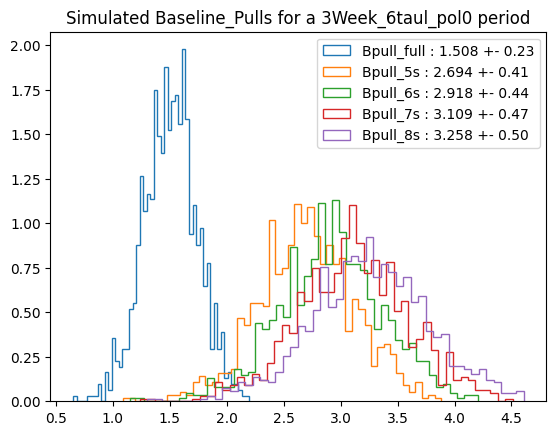

Values for simulated week of data taking at different cuts
Tau long estimation: 186.62691 +/- 0.42810
Tau long estimation: 184.67834 +/- 1.53118
Tau long estimation: 183.52450 +/- 2.04086
Tau long estimation: 181.85822 +/- 2.75027
Tau long estimation: 179.75457 +/- 3.76290
Baseline for simulated week of data taking at different cuts
Baseline estimation: 6.36294 +/- 0.32031
Baseline estimation: 6.36276 +/- 0.17868
Baseline estimation: 6.36276 +/- 0.16510
Baseline estimation: 6.36276 +/- 0.15513
Baseline estimation: 6.36276 +/- 0.14809


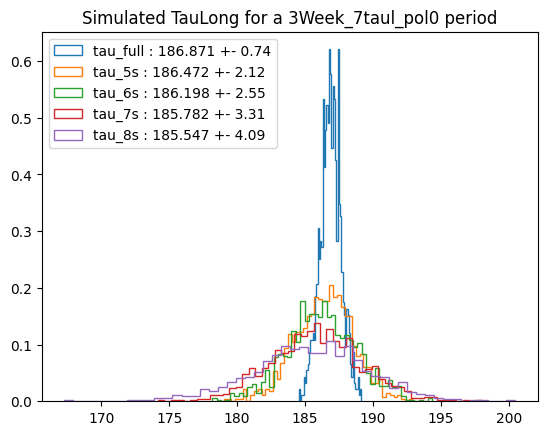

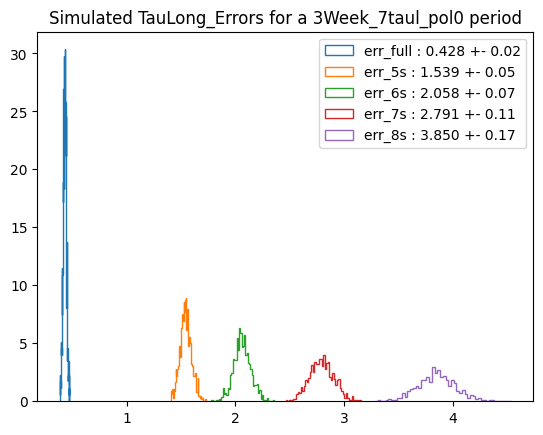

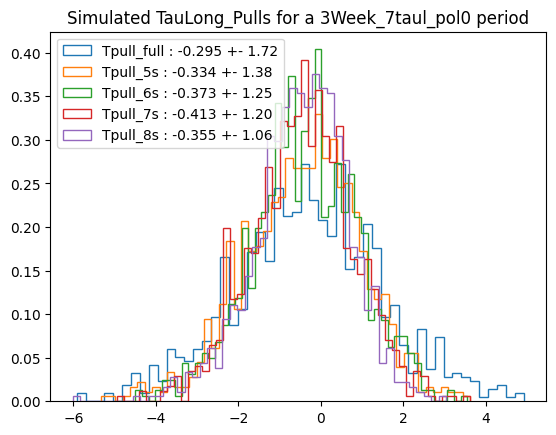

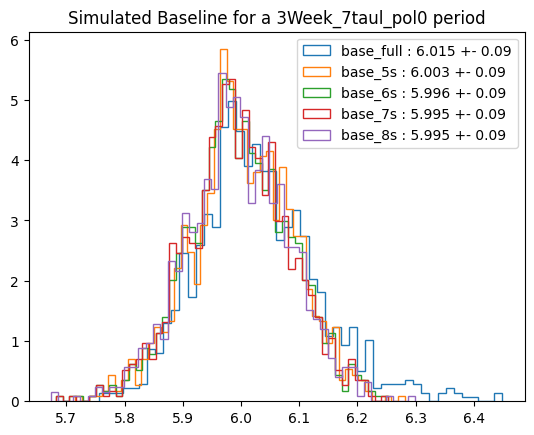

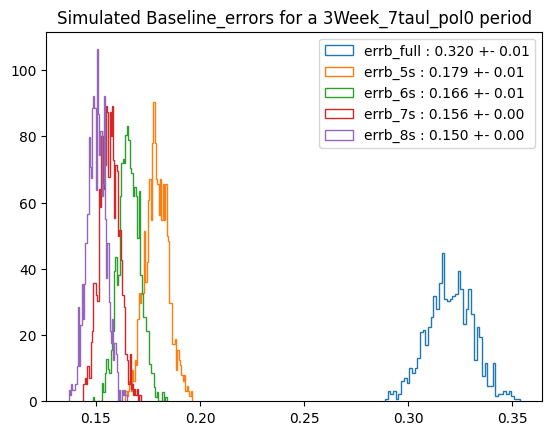

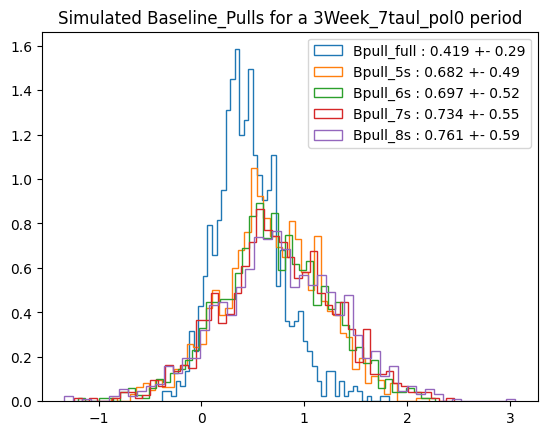

Values for simulated week of data taking at different cuts
Tau long estimation: 186.87132 +/- 0.42819
Tau long estimation: 186.47169 +/- 1.53927
Tau long estimation: 186.19801 +/- 2.05841
Tau long estimation: 185.78197 +/- 2.79060
Tau long estimation: 185.54715 +/- 3.85011
Baseline for simulated week of data taking at different cuts
Baseline estimation: 6.01451 +/- 0.32028
Baseline estimation: 6.00271 +/- 0.17905
Baseline estimation: 5.99559 +/- 0.16581
Baseline estimation: 5.99478 +/- 0.15637
Baseline estimation: 5.99506 +/- 0.15023


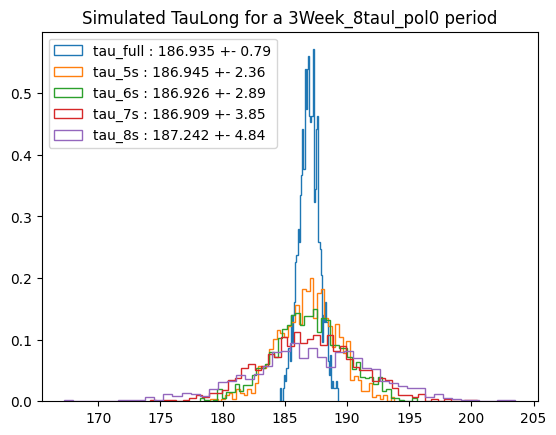

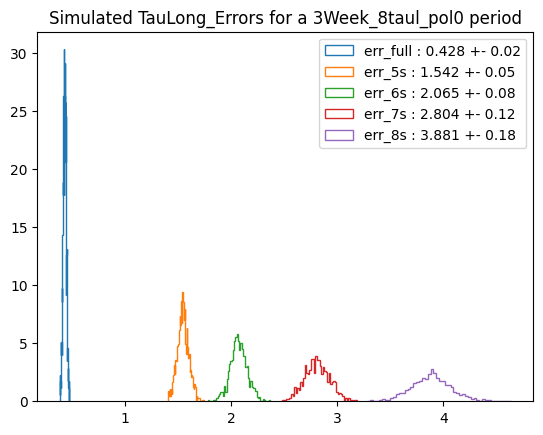

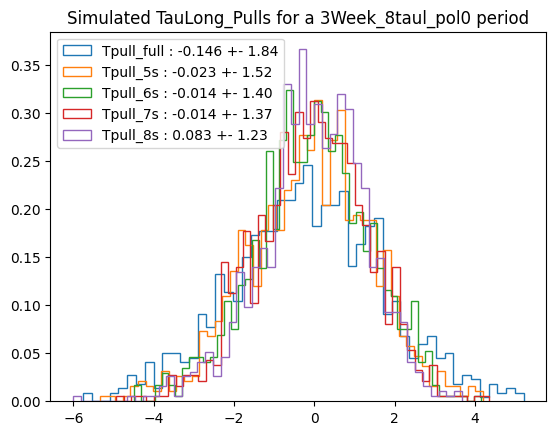

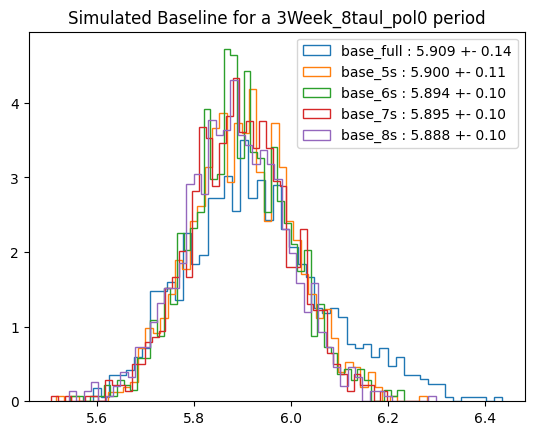

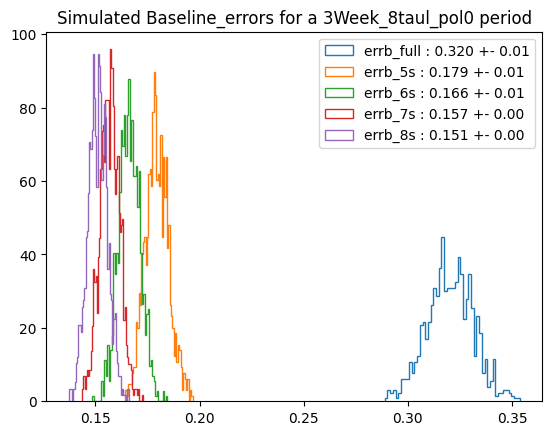

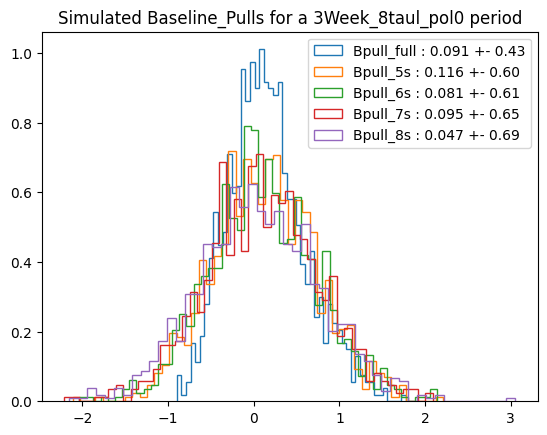

Values for simulated week of data taking at different cuts
Tau long estimation: 186.93543 +/- 0.42826
Tau long estimation: 186.94477 +/- 1.54213
Tau long estimation: 186.92637 +/- 2.06512
Tau long estimation: 186.90878 +/- 2.80354
Tau long estimation: 187.24175 +/- 3.88144
Baseline for simulated week of data taking at different cuts
Baseline estimation: 5.90906 +/- 0.32029
Baseline estimation: 5.90031 +/- 0.17923
Baseline estimation: 5.89356 +/- 0.16611
Baseline estimation: 5.89511 +/- 0.15685
Baseline estimation: 5.88754 +/- 0.15102


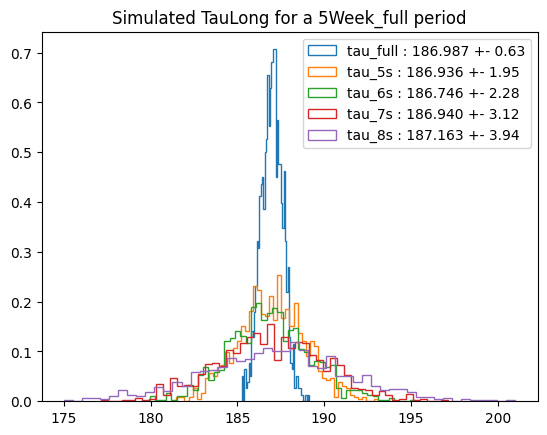

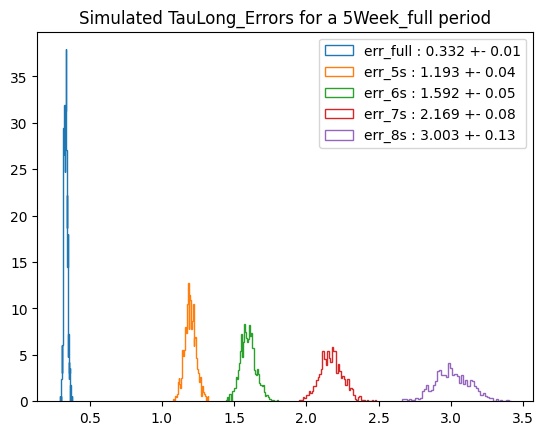

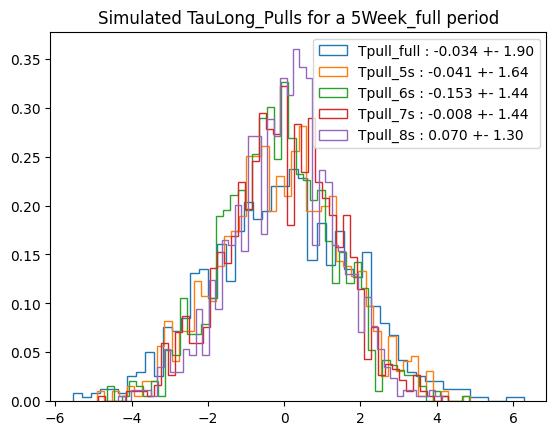

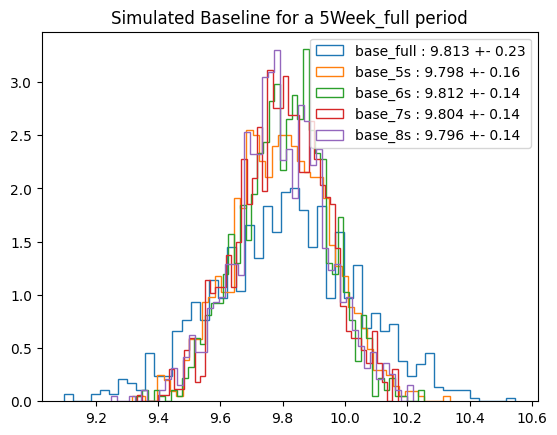

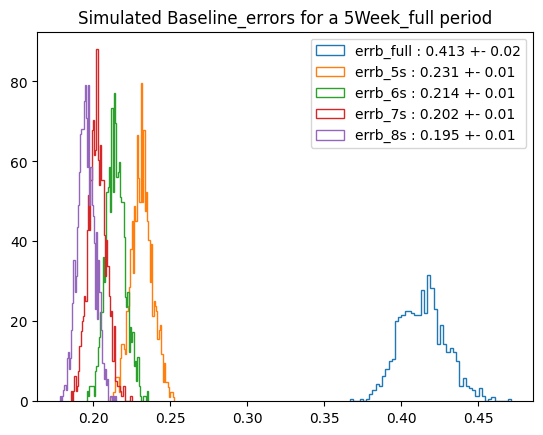

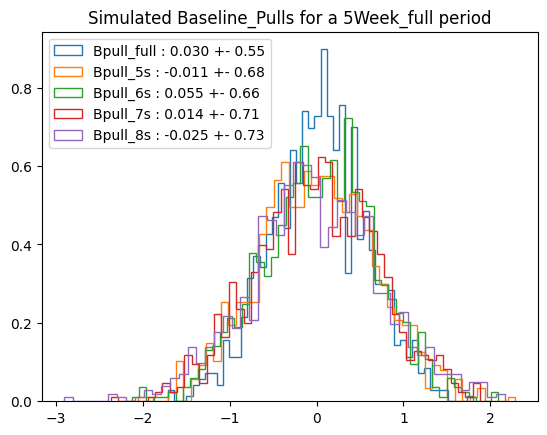

Values for simulated week of data taking at different cuts
Tau long estimation: 186.98671 +/- 0.33160
Tau long estimation: 186.93627 +/- 1.19288
Tau long estimation: 186.74624 +/- 1.59158
Tau long estimation: 186.94023 +/- 2.16908
Tau long estimation: 187.16339 +/- 3.00337
Baseline for simulated week of data taking at different cuts
Baseline estimation: 9.81294 +/- 0.41322
Baseline estimation: 9.79769 +/- 0.23113
Baseline estimation: 9.81182 +/- 0.21396
Baseline estimation: 9.80353 +/- 0.20213
Baseline estimation: 9.79589 +/- 0.19495


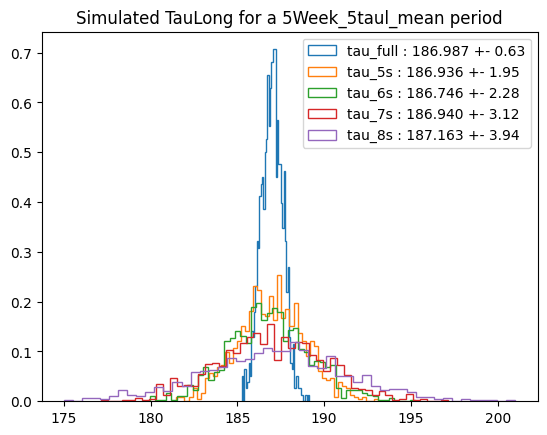

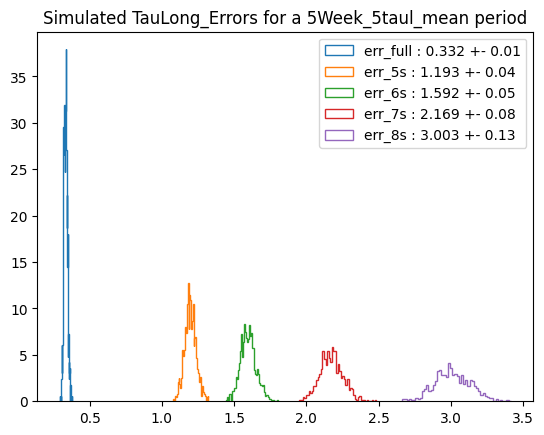

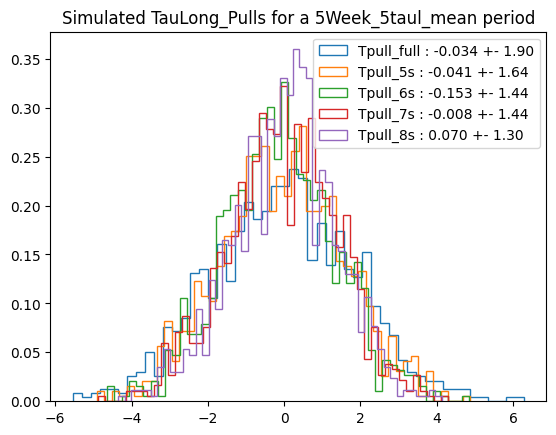

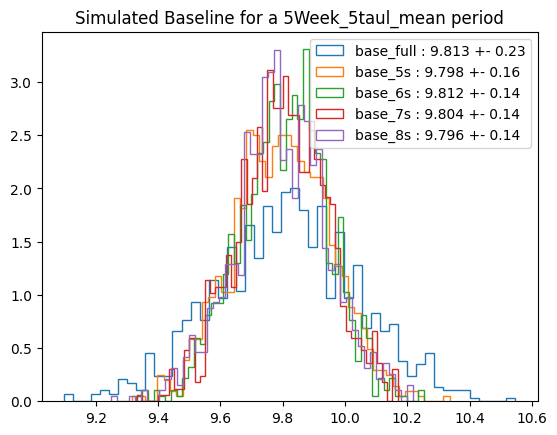

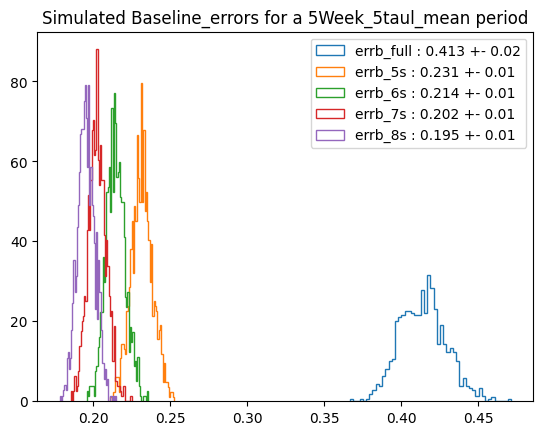

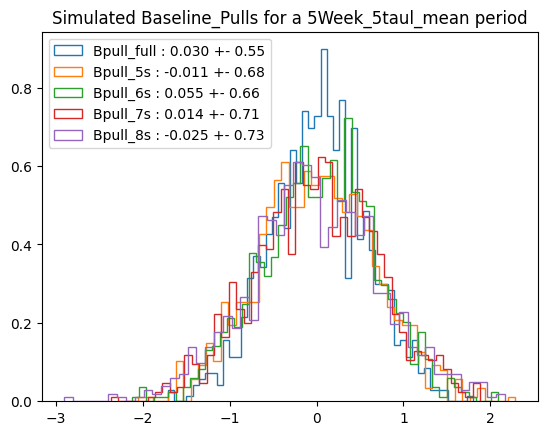

Values for simulated week of data taking at different cuts
Tau long estimation: 186.98671 +/- 0.33160
Tau long estimation: 186.93632 +/- 1.19288
Tau long estimation: 186.74625 +/- 1.59158
Tau long estimation: 186.94023 +/- 2.16908
Tau long estimation: 187.16330 +/- 3.00338
Baseline for simulated week of data taking at different cuts
Baseline estimation: 9.81294 +/- 0.41322
Baseline estimation: 9.79769 +/- 0.23113
Baseline estimation: 9.81182 +/- 0.21396
Baseline estimation: 9.80353 +/- 0.20213
Baseline estimation: 9.79589 +/- 0.19495


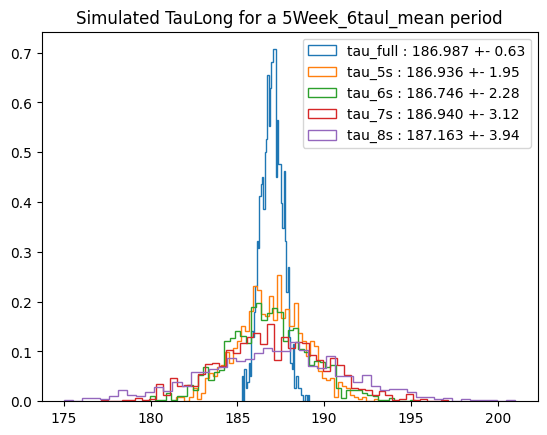

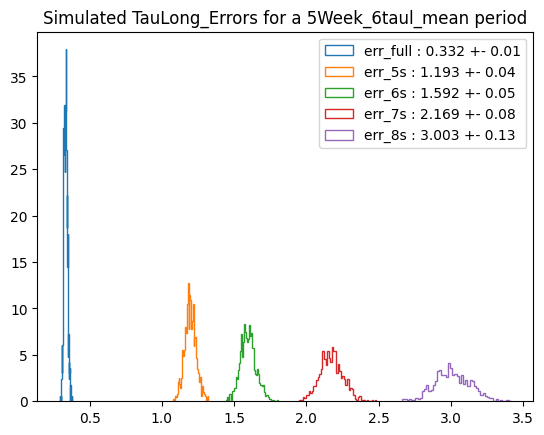

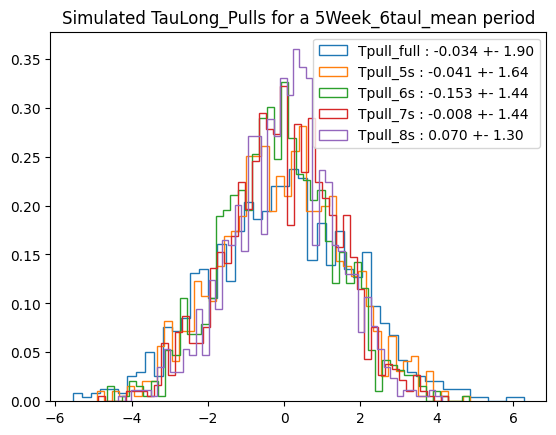

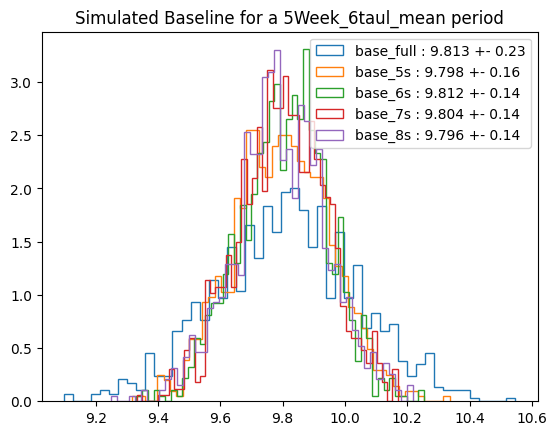

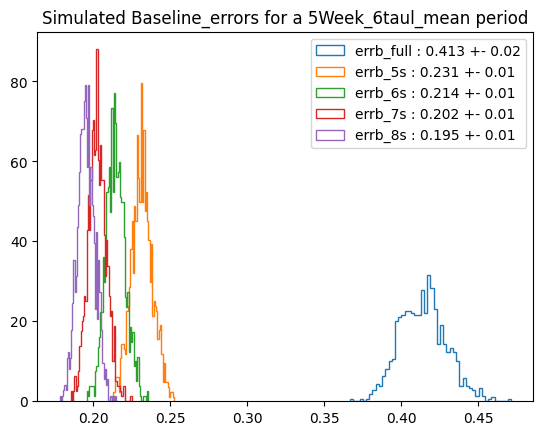

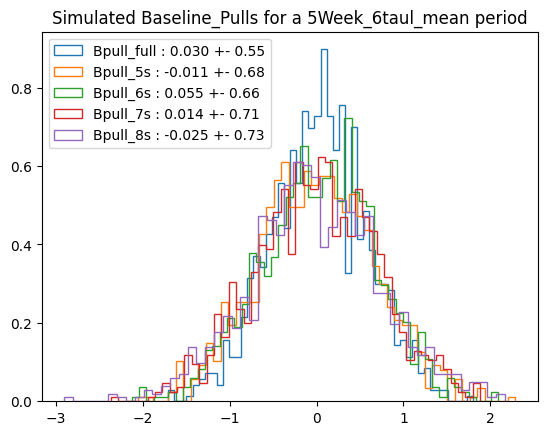

Values for simulated week of data taking at different cuts
Tau long estimation: 186.98671 +/- 0.33160
Tau long estimation: 186.93627 +/- 1.19288
Tau long estimation: 186.74624 +/- 1.59158
Tau long estimation: 186.94022 +/- 2.16908
Tau long estimation: 187.16339 +/- 3.00338
Baseline for simulated week of data taking at different cuts
Baseline estimation: 9.81294 +/- 0.41322
Baseline estimation: 9.79765 +/- 0.23113
Baseline estimation: 9.81182 +/- 0.21396
Baseline estimation: 9.80353 +/- 0.20213
Baseline estimation: 9.79589 +/- 0.19495


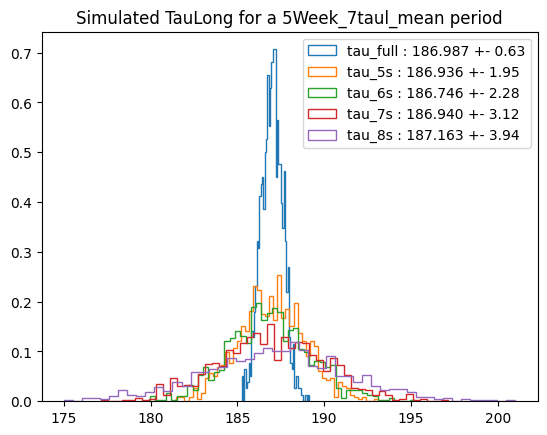

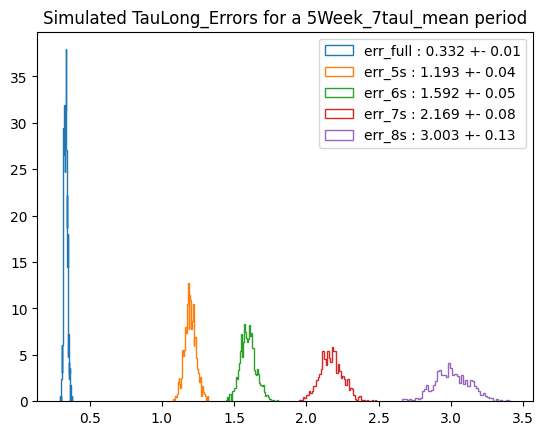

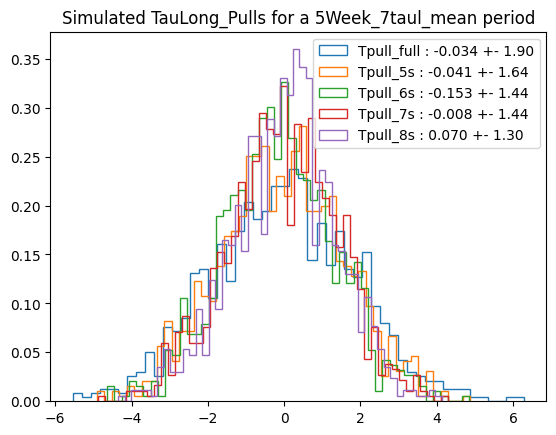

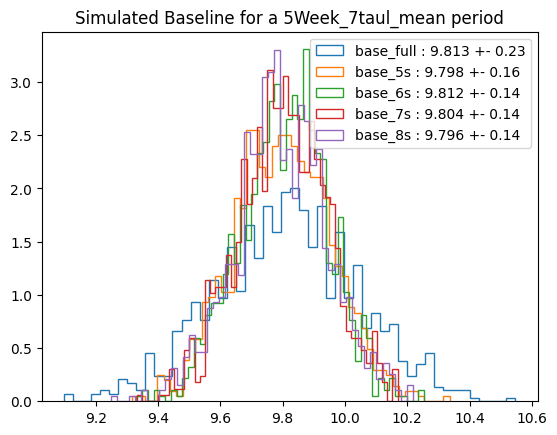

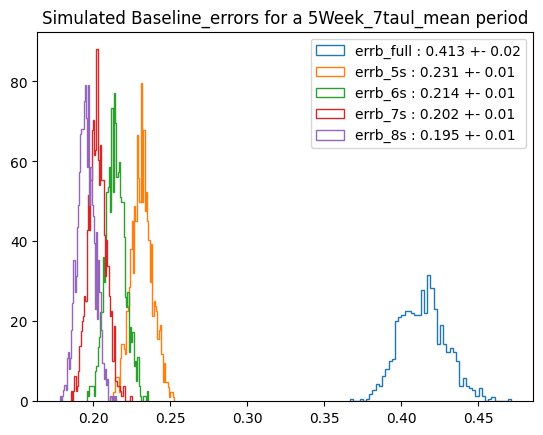

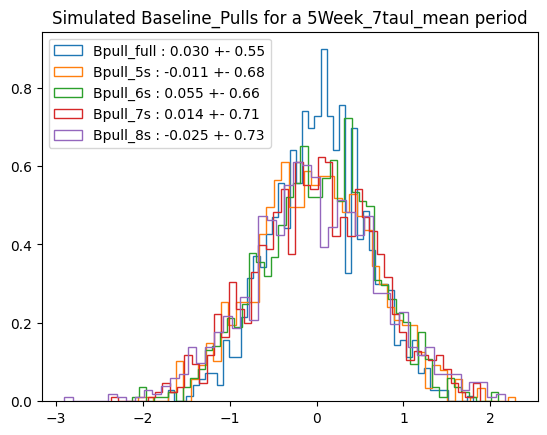

Values for simulated week of data taking at different cuts
Tau long estimation: 186.98671 +/- 0.33160
Tau long estimation: 186.93627 +/- 1.19288
Tau long estimation: 186.74624 +/- 1.59158
Tau long estimation: 186.94022 +/- 2.16908
Tau long estimation: 187.16340 +/- 3.00338
Baseline for simulated week of data taking at different cuts
Baseline estimation: 9.81294 +/- 0.41322
Baseline estimation: 9.79765 +/- 0.23113
Baseline estimation: 9.81182 +/- 0.21396
Baseline estimation: 9.80353 +/- 0.20213
Baseline estimation: 9.79589 +/- 0.19495


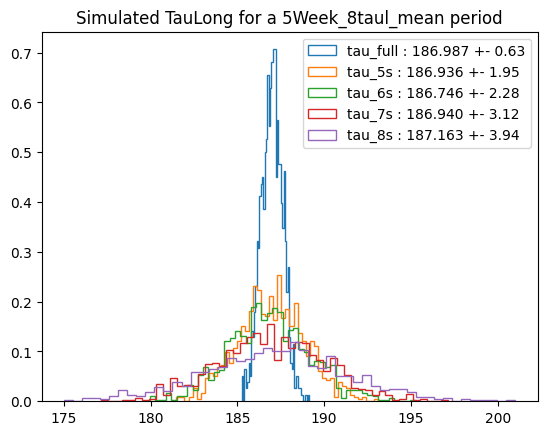

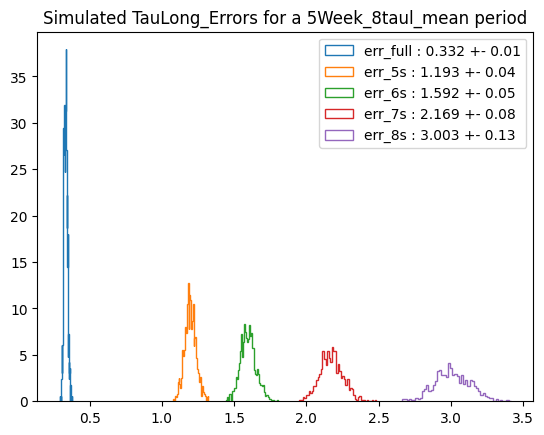

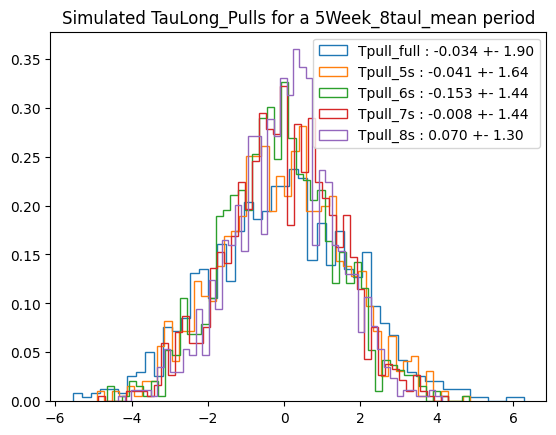

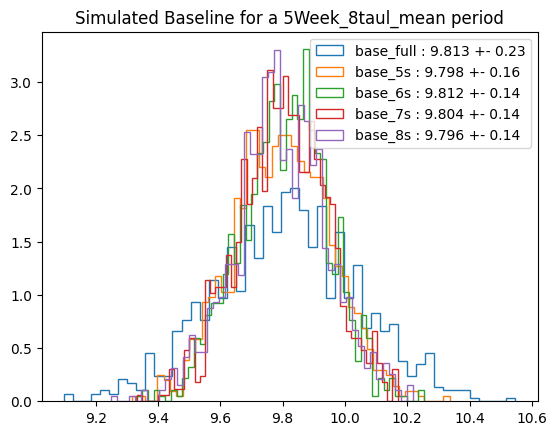

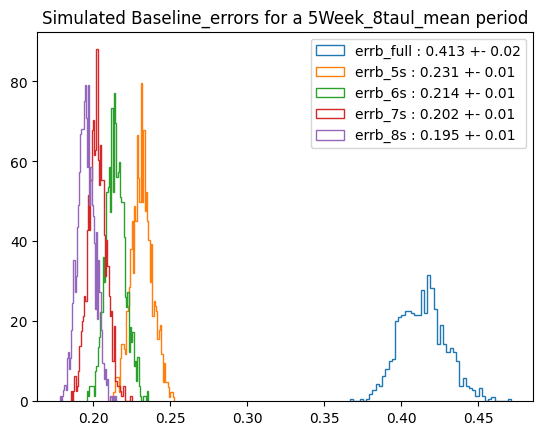

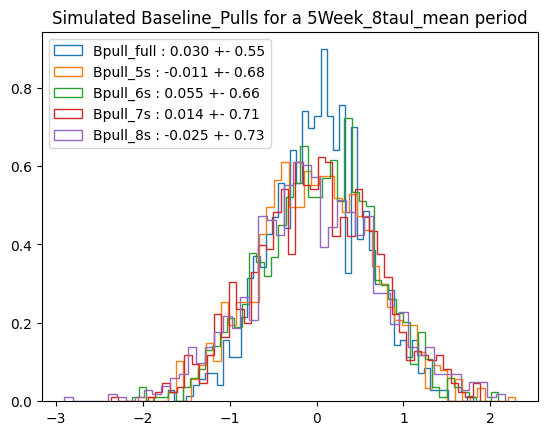

Values for simulated week of data taking at different cuts
Tau long estimation: 186.98671 +/- 0.33160
Tau long estimation: 186.93627 +/- 1.19288
Tau long estimation: 186.74624 +/- 1.59158
Tau long estimation: 186.94022 +/- 2.16908
Tau long estimation: 187.16340 +/- 3.00338
Baseline for simulated week of data taking at different cuts
Baseline estimation: 9.81294 +/- 0.41322
Baseline estimation: 9.79765 +/- 0.23113
Baseline estimation: 9.81182 +/- 0.21396
Baseline estimation: 9.80353 +/- 0.20213
Baseline estimation: 9.79589 +/- 0.19495


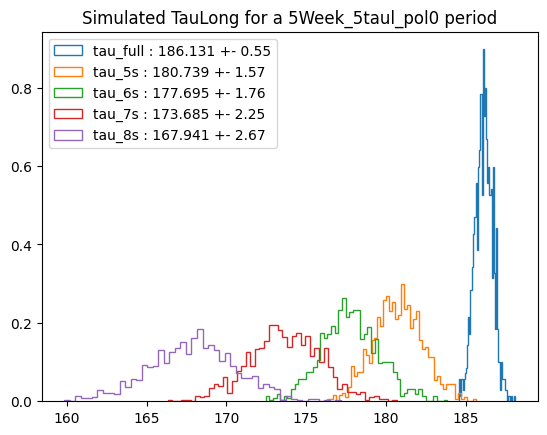

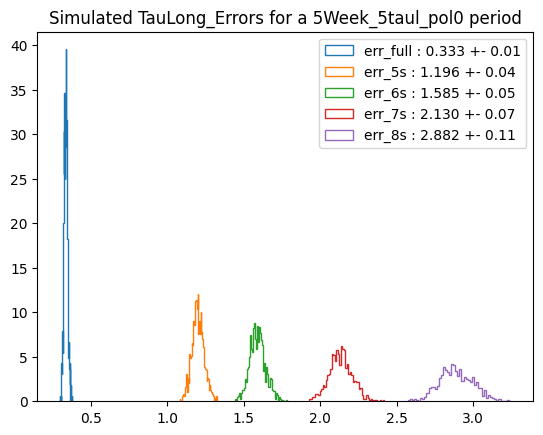

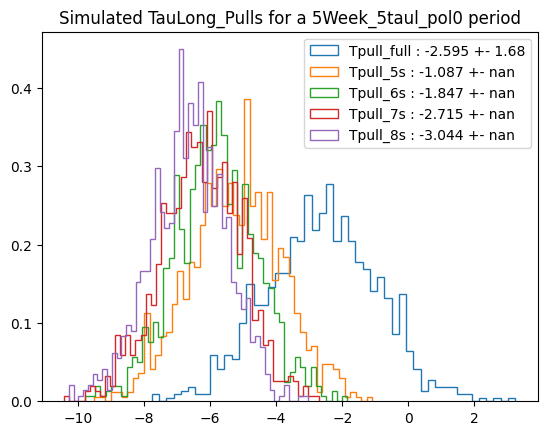

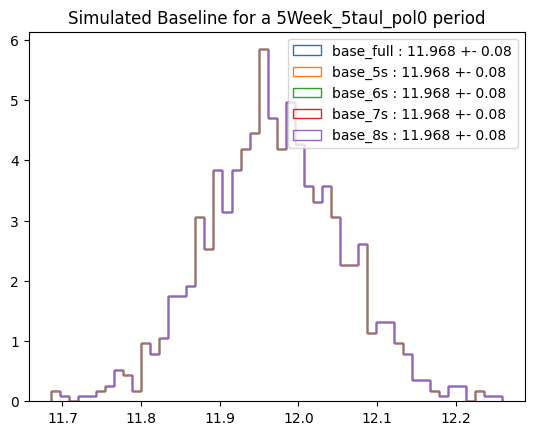

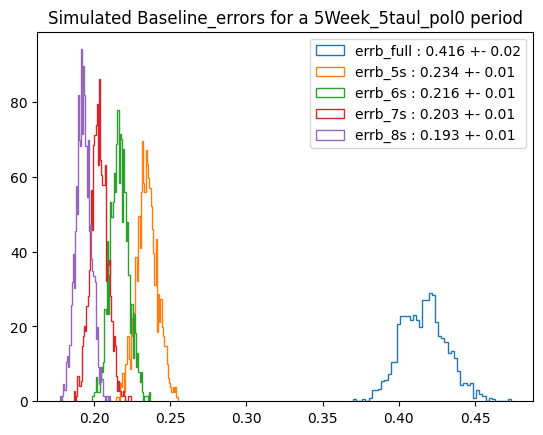

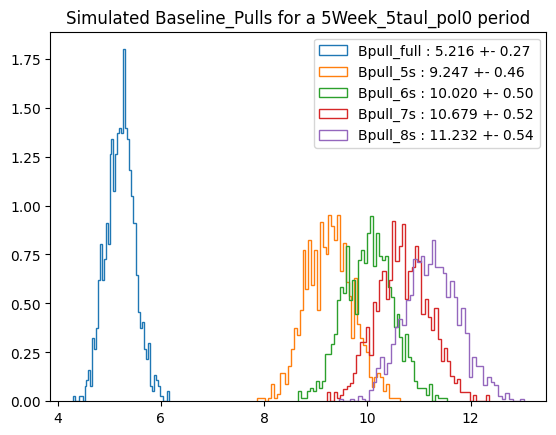

Values for simulated week of data taking at different cuts
Tau long estimation: 186.13082 +/- 0.33298
Tau long estimation: 180.73905 +/- 1.19601
Tau long estimation: 177.69493 +/- 1.58460
Tau long estimation: 173.68450 +/- 2.13039
Tau long estimation: 167.94140 +/- 2.88151
Baseline for simulated week of data taking at different cuts
Baseline estimation: 11.96769 +/- 0.41571
Baseline estimation: 11.96769 +/- 0.23427
Baseline estimation: 11.96769 +/- 0.21638
Baseline estimation: 11.96769 +/- 0.20298
Baseline estimation: 11.96769 +/- 0.19282


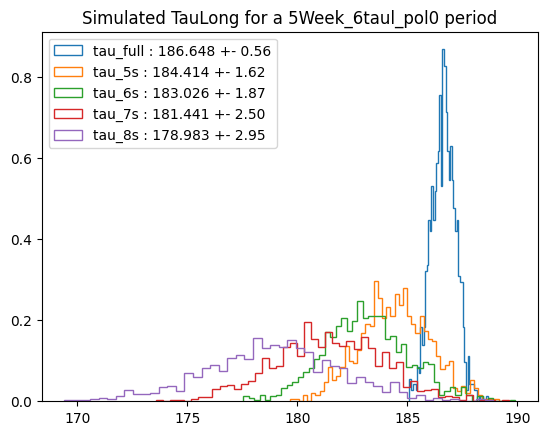

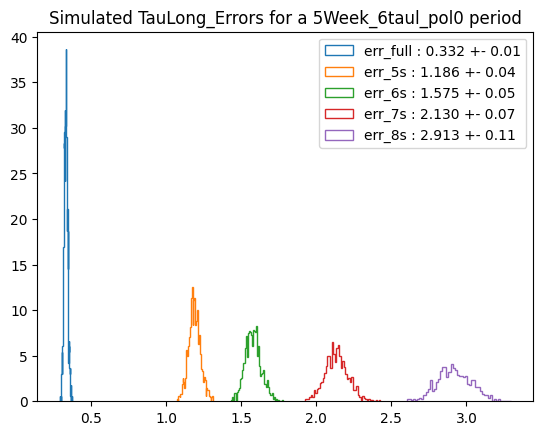

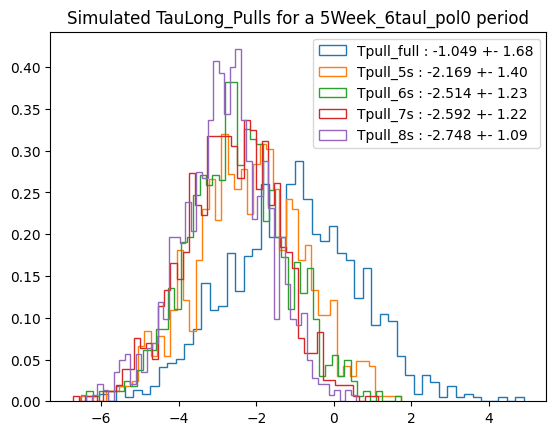

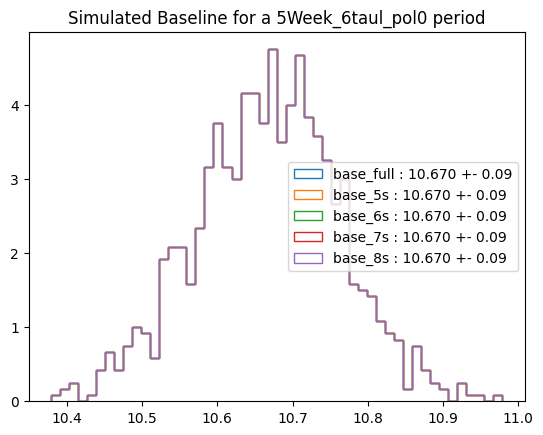

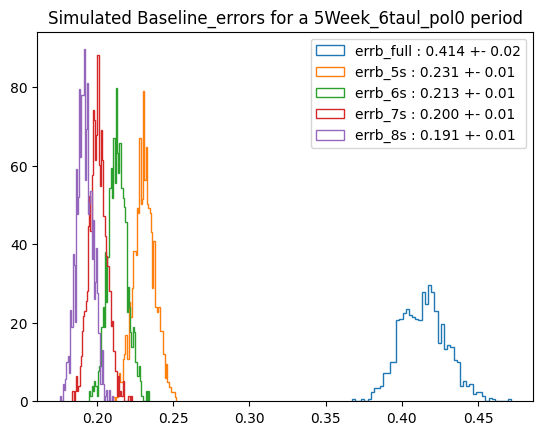

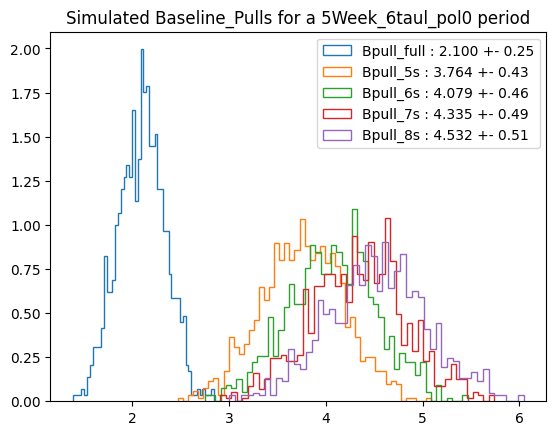

Values for simulated week of data taking at different cuts
Tau long estimation: 186.64788 +/- 0.33159
Tau long estimation: 184.41394 +/- 1.18589
Tau long estimation: 183.02630 +/- 1.57472
Tau long estimation: 181.44137 +/- 2.12993
Tau long estimation: 178.98322 +/- 2.91262
Baseline for simulated week of data taking at different cuts
Baseline estimation: 10.67023 +/- 0.41355
Baseline estimation: 10.67023 +/- 0.23078
Baseline estimation: 10.67023 +/- 0.21304
Baseline estimation: 10.67023 +/- 0.20026
Baseline estimation: 10.67023 +/- 0.19147


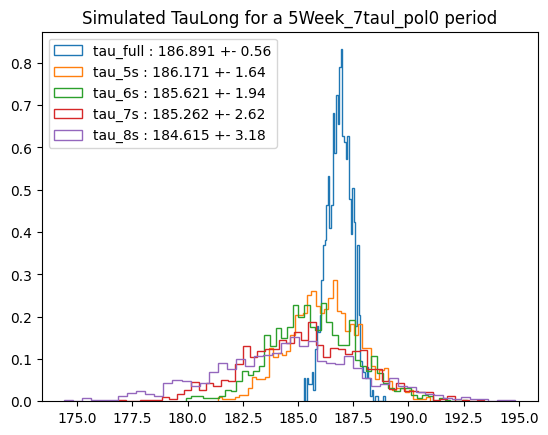

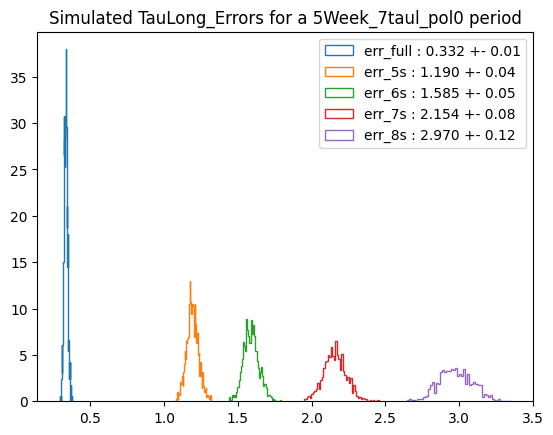

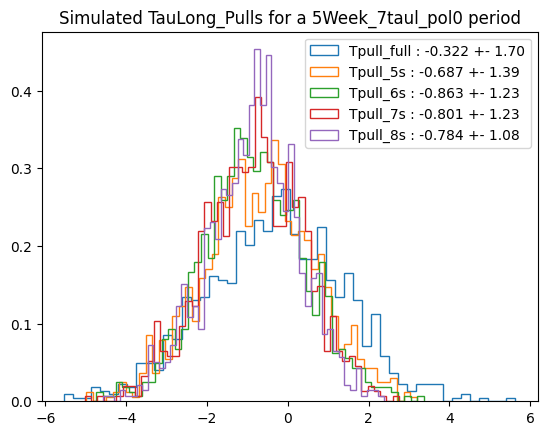

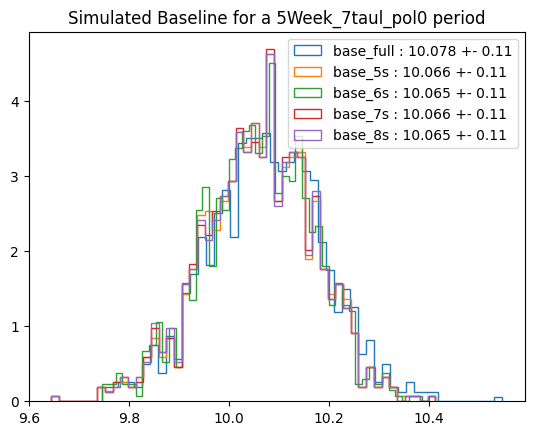

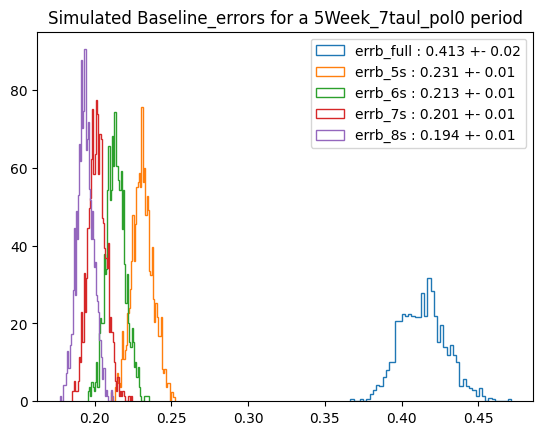

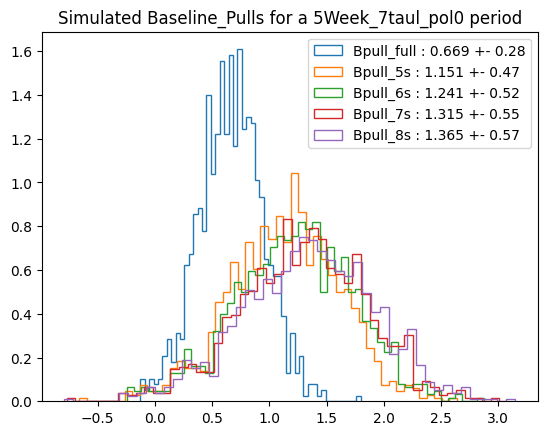

Values for simulated week of data taking at different cuts
Tau long estimation: 186.89127 +/- 0.33152
Tau long estimation: 186.17133 +/- 1.18974
Tau long estimation: 185.62057 +/- 1.58478
Tau long estimation: 185.26217 +/- 2.15391
Tau long estimation: 184.61455 +/- 2.96978
Baseline for simulated week of data taking at different cuts
Baseline estimation: 10.07753 +/- 0.41321
Baseline estimation: 10.06551 +/- 0.23083
Baseline estimation: 10.06473 +/- 0.21345
Baseline estimation: 10.06558 +/- 0.20129
Baseline estimation: 10.06536 +/- 0.19353


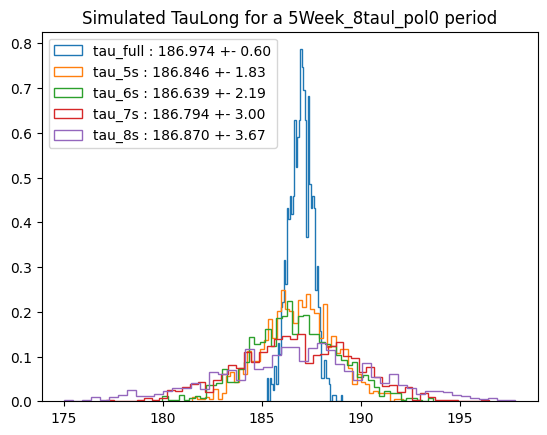

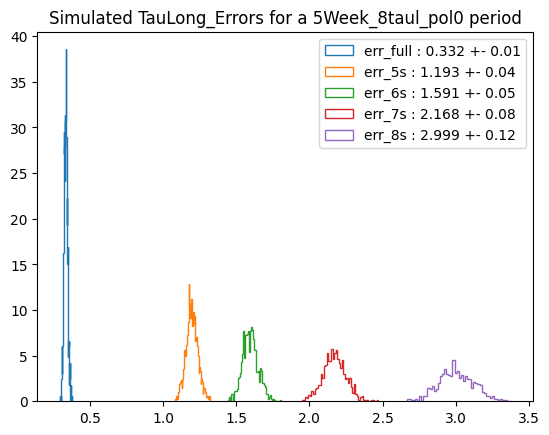

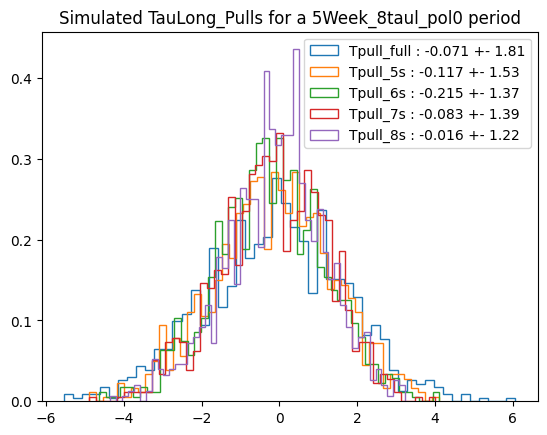

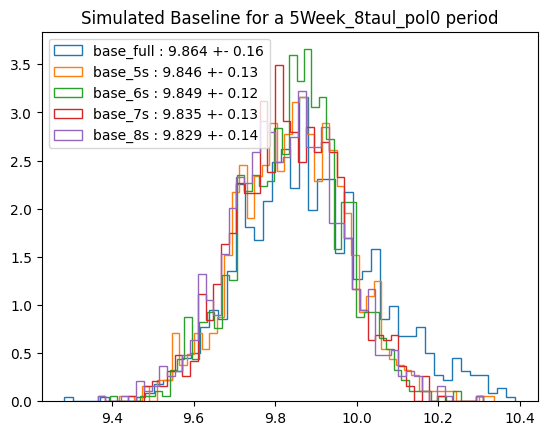

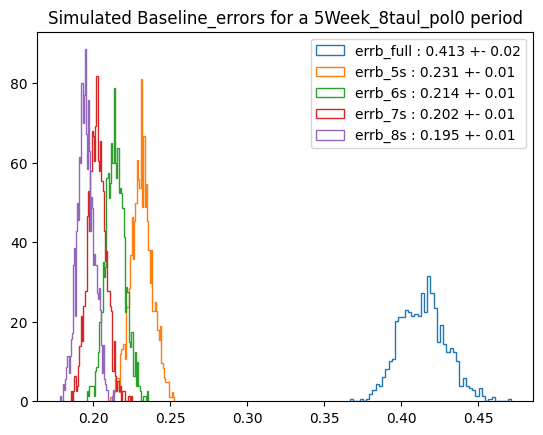

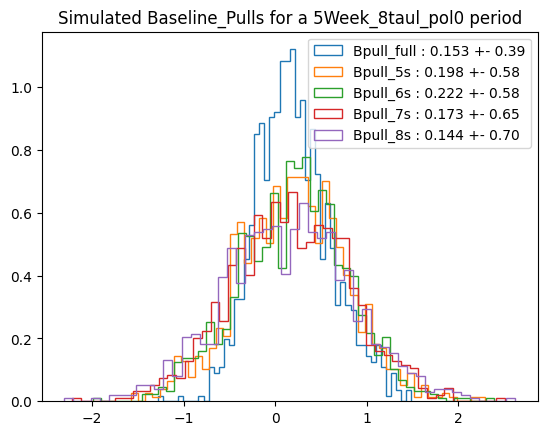

Values for simulated week of data taking at different cuts
Tau long estimation: 186.97444 +/- 0.33159
Tau long estimation: 186.84583 +/- 1.19262
Tau long estimation: 186.63882 +/- 1.59069
Tau long estimation: 186.79361 +/- 2.16800
Tau long estimation: 186.87004 +/- 2.99931
Baseline for simulated week of data taking at different cuts
Baseline estimation: 9.86373 +/- 0.41322
Baseline estimation: 9.84643 +/- 0.23109
Baseline estimation: 9.84897 +/- 0.21387
Baseline estimation: 9.83492 +/- 0.20204
Baseline estimation: 9.82886 +/- 0.19474


In [ ]:
#run for all dataframes
for data, weeks in zip ([stats,stats3,stats5], ["1Week","3Week","5Week"]):
    info= plotter(data, weeks , "yes")

    printer =["Tau Short estimation: %.5f +/- %.5f" %(i,j) for i,j in zip(info[0], info[1]) ]
    print("Values for simulated week of data taking at different cuts")
    for i in printer:
      print(i)

    printer =["Tau long estimation: %.5f +/- %.5f" %(i,j) for i,j in zip(info[3], info[4]) ]
    print("Values for simulated week of data taking at different cuts")
    for i in printer:
      print(i)

    print("Baseline for simulated week of data taking at different cuts")
    printer =["Baseline estimation: %.5f +/- %.5f" %(i,j) for i,j in zip(info[6], info[7]) ]
    for i in printer:
      print(i)

    printer =["Tau long estimation: %.5f +/- %.5f" %(i,j) for i,j in zip(info[9], info[10]) ]
    print("Values for simulated week of data taking at different cuts")
    for i in printer:
      print(i)